<a href="https://colab.research.google.com/github/fishee82oo/nfs-oil-price-prediction/blob/training/GDELT_Model_Training_Pleng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q google-cloud-storage pyarrow pycountry tqdm xgboost scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 27.5 MB/s eta 0:00:00


In [ ]:
import importlib.util, sys, os, io, json, gzip
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
import xgboost as xgb
from scipy import stats

In [ ]:
try:
    from google.colab import auth
    auth.authenticate_user()
except Exception:
    pass

import google.auth
from google.cloud import storage
credentials, default_project = google.auth.default()
client = storage.Client(project=default_project, credentials=credentials)

In [ ]:
BUCKET_NAME = os.environ.get("GCS_BUCKET_NAME", "gdelt_raw_3_years")
PROCESSED_PREFIX = os.environ.get("GCS_PROCESSED_PATH", "processed_data/")

bucket = client.bucket(BUCKET_NAME)
blobs = list(client.list_blobs(BUCKET_NAME, prefix=PROCESSED_PREFIX))
final_blobs = [b for b in blobs if b.name.startswith(f"{PROCESSED_PREFIX}final_aligned_data_") and b.name.endswith(".json.gz")]
final_blobs_sorted = sorted(final_blobs, key=lambda b: b.name, reverse=True)

if len(final_blobs_sorted) == 0:
    raise SystemExit("No final_aligned_data_*.json.gz found")

latest_blob = final_blobs_sorted[0]
local_download_path = "/tmp/latest_final_aligned_data.json.gz"

with open(local_download_path, "wb") as f:
    f.write(latest_blob.download_as_bytes())

print(f"Downloaded: {latest_blob.name}")
print(f"Size: {os.path.getsize(local_download_path) / (1024*1024):.2f} MB")

Downloaded: processed_data/final_aligned_data_20250908.json.gz
Size: 2.37 MB


In [ ]:
with gzip.open(local_download_path, "rt", encoding="utf-8") as f:
    raw = f.read()

records = json.loads(raw)
df = pd.DataFrame.from_records(records)
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

import pycountry

def to_iso3(name):
    try:
        c = pycountry.countries.lookup(name)
        return c.alpha_3
    except Exception:
        s = str(name).upper()
        s2 = "".join([c for c in s if c.isalpha() or c==" "]).strip().replace(" ", "_")
        return s2

df["country_iso3"] = df["country"].fillna("UNKNOWN").apply(to_iso3)
df["node_id"] = df["country_iso3"].astype(str) + "_" + df["date"].dt.strftime("%Y%m%d")

print(f"Data shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

Data shape: (143401, 15)
Date range: 2022-08-25 00:00:00 to 2025-08-25 00:00:00


In [ ]:
df = df.sort_values(['country_iso3', 'date']).reset_index(drop=True)

for col in ['wti_price', 'brent_price']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df['wti_return'] = df.groupby('country_iso3')['wti_price'].pct_change()
df['wti_delta'] = df.groupby('country_iso3')['wti_price'].diff()

for lag in [1, 2, 3, 5, 7, 14, 30]:
    df[f'wti_delta_lag{lag}'] = df.groupby('country_iso3')['wti_delta'].shift(lag)
    df[f'wti_return_lag{lag}'] = df.groupby('country_iso3')['wti_return'].shift(lag)

for window in [5, 10, 20, 30]:
    df[f'wti_return_ma{window}'] = df.groupby('country_iso3')['wti_return'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    df[f'wti_return_std{window}'] = df.groupby('country_iso3')['wti_return'].transform(lambda x: x.rolling(window, min_periods=1).std())
    df[f'wti_delta_ma{window}'] = df.groupby('country_iso3')['wti_delta'].transform(lambda x: x.rolling(window, min_periods=1).mean())

df['wti_momentum_5_20'] = df['wti_return_ma5'] - df['wti_return_ma20']
df['wti_momentum_10_30'] = df['wti_return_ma10'] - df['wti_return_ma30']

df['wti_rsi'] = df.groupby('country_iso3')['wti_return'].transform(
    lambda x: 100 - 100/(1 + x.rolling(14).apply(lambda y: (y>0).sum()/(y<0).sum() if (y<0).sum()>0 else 1))
)

In [ ]:
event_cols = [c for c in df.columns if 'event' in c.lower() or 'goldstein' in c.lower() or 'tone' in c.lower()]
theme_cols = [c for c in df.columns if c.startswith('theme_')]

for col in event_cols + theme_cols:
    if col in df.columns and df[col].dtype != 'object':
        df[f'{col}_change'] = df.groupby('country_iso3')[col].diff()
        df[f'{col}_pct_change'] = df.groupby('country_iso3')[col].pct_change()

        rolling_mean = df.groupby('country_iso3')[col].transform(lambda x: x.rolling(20, min_periods=5).mean())
        rolling_std = df.groupby('country_iso3')[col].transform(lambda x: x.rolling(20, min_periods=5).std())
        df[f'{col}_zscore'] = (df[col] - rolling_mean) / (rolling_std + 1e-8)
        df[f'{col}_spike'] = (df[f'{col}_zscore'] > 2).astype(int)

In [ ]:
df['wti_delta_next'] = df.groupby('country_iso3')['wti_delta'].shift(-1)
df['wti_return_next'] = df.groupby('country_iso3')['wti_return'].shift(-1)

df['wti_delta_surprise'] = df['wti_delta_next'] - df['wti_delta']
df['wti_return_surprise'] = df['wti_return_next'] - df['wti_return']

df['wti_direction_next'] = (df['wti_delta_next'] > 0).astype(int)
df['wti_direction_correct'] = (np.sign(df['wti_delta_next']) == np.sign(df['wti_delta'])).astype(int)

for horizon in [3, 5, 7]:
    df[f'wti_return_{horizon}d'] = df.groupby('country_iso3')['wti_price'].transform(
        lambda x: x.pct_change(horizon).shift(-horizon)
    )
    df[f'wti_return_{horizon}d_ma'] = df[f'wti_return_{horizon}d'].rolling(20, min_periods=5).mean()

df['wti_volatility_next'] = df.groupby('country_iso3')['wti_return'].transform(
    lambda x: x.rolling(5).std().shift(-1)
)

df = df.dropna(subset=['wti_delta_next', 'wti_delta_lag1']).reset_index(drop=True)

In [ ]:
feature_cols = []

temporal_features = [c for c in df.columns if 'lag' in c or 'ma' in c or 'std' in c or 'momentum' in c or 'rsi' in c]
change_features = [c for c in df.columns if '_change' in c or '_pct_change' in c or '_zscore' in c or '_spike' in c]
original_features = [c for c in df.columns if c not in ['country', 'date', 'node_id', 'country_iso3']
                    and not any(x in c for x in ['next', 'surprise', 'direction', 'volatility'])
                    and c not in temporal_features + change_features]

feature_cols = temporal_features + change_features + original_features
feature_cols = [c for c in feature_cols if df[c].dtype != 'object']
feature_cols = list(dict.fromkeys(feature_cols))

print(f"Total features: {len(feature_cols)}")
print(f"Temporal: {len(temporal_features)}, Change: {len(change_features)}, Original: {len(original_features)}")

Total features: 76
Temporal: 32, Change: 28, Original: 16


In [ ]:
df_model = df[['date', 'country_iso3'] + feature_cols + ['wti_delta_next', 'wti_delta_surprise', 'wti_direction_next']].copy()
df_model = df_model.replace([np.inf, -np.inf], np.nan)
df_model = df_model.dropna(subset=['wti_delta_next']).reset_index(drop=True)

cutoff_date = df_model['date'].quantile(0.8)
train_mask = df_model['date'] < cutoff_date

X_train = df_model.loc[train_mask, feature_cols].fillna(0).values
X_test = df_model.loc[~train_mask, feature_cols].fillna(0).values

y_train = df_model.loc[train_mask, 'wti_delta_next'].values
y_test = df_model.loc[~train_mask, 'wti_delta_next'].values

y_train_surprise = df_model.loc[train_mask, 'wti_delta_surprise'].values
y_test_surprise = df_model.loc[~train_mask, 'wti_delta_surprise'].values

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Train dates: {df_model.loc[train_mask, 'date'].min()} to {df_model.loc[train_mask, 'date'].max()}")
print(f"Test dates: {df_model.loc[~train_mask, 'date'].min()} to {df_model.loc[~train_mask, 'date'].max()}")

Train: (113952, 76), Test: (28679, 76)
Train dates: 2022-08-29 00:00:00 to 2024-12-27 00:00:00
Test dates: 2024-12-30 00:00:00 to 2025-08-22 00:00:00


In [ ]:
persistence_pred = df_model.loc[~train_mask, 'wti_delta_lag1'].values
persistence_r2 = r2_score(y_test, persistence_pred)
persistence_mae = mean_absolute_error(y_test, persistence_pred)
persistence_acc = np.mean(np.sign(persistence_pred) == np.sign(y_test))

print("Persistence Baseline:")
print(f"  R2: {persistence_r2:.4f}")
print(f"  MAE: {persistence_mae:.4f}")
print(f"  Direction Accuracy: {persistence_acc:.4f}")

Persistence Baseline:
  R2: -0.8417
  MAE: 1.5387
  Direction Accuracy: 0.5251


In [ ]:
scaler_X = RobustScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train = y_train
y_test = y_test


In [ ]:
xgb_params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.03,
    'n_estimators': 500,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'colsample_bylevel': 0.7,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'min_child_weight': 5,
    'gamma': 0.1,
    'random_state': 42,
    'n_jobs': -1,
}

model_main = xgb.XGBRegressor(**xgb_params)
model_main.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    verbose=False
)

y_pred = model_main.predict(X_test_scaled)

test_r2 = r2_score(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_direction_acc = np.mean(np.sign(y_pred) == np.sign(y_test))

print("\nMain Model (Predicting wti_delta_next):")
print(f"  R2: {test_r2:.4f}")
print(f"  MAE: {test_mae:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  Direction Accuracy: {test_direction_acc:.4f}")
print(f"  Beat Persistence: {test_r2 > persistence_r2}")



Main Model (Predicting wti_delta_next):
  R2: 0.0951
  MAE: 1.1646
  RMSE: 1.4950
  Direction Accuracy: 0.6039
  Beat Persistence: True


In [ ]:
model_surprise = xgb.XGBRegressor(**xgb_params)
model_surprise.fit(
    X_train_scaled, y_train_surprise,
    eval_set=[(X_train_scaled, y_train_surprise), (X_test_scaled, y_test_surprise)],
    verbose=False
)

y_pred_surprise = model_surprise.predict(X_test_scaled)
y_pred_combined = persistence_pred + y_pred_surprise

surprise_r2 = r2_score(y_test, y_pred_combined)
surprise_mae = mean_absolute_error(y_test, y_pred_combined)
surprise_acc = np.mean(np.sign(y_pred_combined) == np.sign(y_test))

print("\nSurprise Model (Persistence + Predicted Surprise):")
print(f"  R2: {surprise_r2:.4f}")
print(f"  MAE: {surprise_mae:.4f}")
print(f"  Direction Accuracy: {surprise_acc:.4f}")
print(f"  Beat Persistence: {surprise_r2 > persistence_r2}")


Surprise Model (Persistence + Predicted Surprise):
  R2: -1.7712
  MAE: 1.9003
  Direction Accuracy: 0.5632
  Beat Persistence: False


In [ ]:
ensemble_predictions = []
ensemble_models = []

for seed in [42, 123, 456, 789, 1024]:
    xgb_params['random_state'] = seed
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(
        X_train_scaled, y_train,
        eval_set=[(X_test_scaled, y_test)],
        verbose=False,
    )

    pred = model.predict(X_test_scaled)
    ensemble_predictions.append(pred)
    ensemble_models.append(model)

ensemble_pred = np.mean(ensemble_predictions, axis=0)
ensemble_r2 = r2_score(y_test, ensemble_pred)
ensemble_mae = mean_absolute_error(y_test, ensemble_pred)
ensemble_acc = np.mean(np.sign(ensemble_pred) == np.sign(y_test))

print("\nEnsemble Model (5 seeds):")
print(f"  R2: {ensemble_r2:.4f}")
print(f"  MAE: {ensemble_mae:.4f}")
print(f"  Direction Accuracy: {ensemble_acc:.4f}")
print(f"  Beat Persistence: {ensemble_r2 > persistence_r2}")



Ensemble Model (5 seeds):
  R2: 0.1510
  MAE: 1.1228
  Direction Accuracy: 0.6186
  Beat Persistence: True


In [ ]:
# Verify persistence calculation
persistence_pred = df_model.loc[~train_mask, 'wti_delta_lag1'].fillna(0).values
print(f"Persistence NaN count: {np.isnan(persistence_pred).sum()}")
print(f"Actual NaN count: {np.isnan(y_test).sum()}")
print(f"Correlation between persistence and actual: {np.corrcoef(persistence_pred, y_test)[0,1]}")

Persistence NaN count: 0
Actual NaN count: 0
Correlation between persistence and actual: 0.07960464545744876


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from tqdm import tqdm

class SimpleGraphFeatureExtractor:
    def __init__(self, n_components=16):
        self.n_components = n_components
        self.pca = None

    def create_adjacency_matrix(self, df_snapshot):
        unique_countries = df_snapshot['country_iso3'].unique()
        n_countries = len(unique_countries)
        country_to_idx = {c: i for i, c in enumerate(unique_countries)}

        adj_matrix = np.eye(n_countries, dtype=np.float32)

        opec_countries = ['SAU', 'IRQ', 'IRN', 'KWT', 'ARE', 'VEN', 'NGA', 'LBY', 'DZA', 'AGO']
        for i, c1 in enumerate(unique_countries):
            for j, c2 in enumerate(unique_countries):
                if c1 in opec_countries and c2 in opec_countries and i != j:
                    adj_matrix[i, j] = 0.8

        if 'goldstein' in df_snapshot.columns:
            for i in range(n_countries):
                for j in range(i+1, n_countries):
                    country_i_data = df_snapshot[df_snapshot['country_iso3'] == unique_countries[i]]
                    country_j_data = df_snapshot[df_snapshot['country_iso3'] == unique_countries[j]]

                    if len(country_i_data) > 0 and len(country_j_data) > 0:
                        goldstein_i = country_i_data['goldstein'].mean()
                        goldstein_j = country_j_data['goldstein'].mean()

                        if not np.isnan(goldstein_i) and not np.isnan(goldstein_j):
                            similarity = 1.0 / (1.0 + abs(goldstein_i - goldstein_j))
                            if similarity > 0.5:
                                adj_matrix[i, j] = max(adj_matrix[i, j], similarity)
                                adj_matrix[j, i] = max(adj_matrix[j, i], similarity)

        return adj_matrix, country_to_idx

    def extract_spectral_features(self, adj_matrix, node_features):
        n_nodes = adj_matrix.shape[0]
        n_features = node_features.shape[1] if len(node_features.shape) > 1 else 1

        if n_nodes < 3:
            return np.zeros((1, self.n_components))

        degree_matrix = np.diag(adj_matrix.sum(axis=1))
        laplacian = degree_matrix - adj_matrix

        try:
            if n_nodes > 3:
                laplacian_sparse = csr_matrix(laplacian)
                k = min(3, n_nodes - 1)
                eigenvalues, eigenvectors = eigsh(laplacian_sparse, k=k, which='SM')
                spectral_features = eigenvectors.T
            else:
                spectral_features = np.random.randn(1, n_nodes) * 0.01
        except:
            spectral_features = np.random.randn(1, n_nodes) * 0.01

        graph_features = []

        if n_features > 0:
            graph_features.append(np.mean(node_features, axis=0))
            graph_features.append(np.std(node_features, axis=0))
            graph_features.append(np.max(node_features, axis=0))
            graph_features.append(np.min(node_features, axis=0))

        for i in range(min(spectral_features.shape[0], 3)):
            if n_features > 0 and spectral_features.shape[1] == n_nodes:
                weighted_features = spectral_features[i].reshape(-1, 1) * node_features
                graph_features.append(np.mean(weighted_features, axis=0))

        if len(graph_features) > 0:
            combined_features = np.concatenate(graph_features)
        else:
            combined_features = np.zeros(self.n_components)

        final_dim = min(len(combined_features), self.n_components)
        if len(combined_features) > self.n_components:
            combined_features = combined_features[:self.n_components]
        elif len(combined_features) < self.n_components:
            padded = np.zeros(self.n_components)
            padded[:len(combined_features)] = combined_features
            combined_features = padded

        return combined_features.reshape(1, -1)

    def extract_graph_features(self, df_model, feature_cols):
        print("Extracting graph-based features...")

        dates = df_model['date'].unique()
        graph_features_dict = {}

        valid_dates = 0
        for date in tqdm(dates, desc="Processing dates"):
            date_data = df_model[df_model['date'] == date]

            if len(date_data['country_iso3'].unique()) < 2:
                continue

            adj_matrix, country_to_idx = self.create_adjacency_matrix(date_data)

            features_matrix = []
            for country in date_data['country_iso3'].unique():
                country_data_sub = date_data[date_data['country_iso3'] == country]
                if len(country_data_sub) > 0:
                    features = country_data_sub[feature_cols].iloc[0].values
                    features_matrix.append(features)

            if len(features_matrix) > 0:
                features_matrix = np.array(features_matrix, dtype=np.float32)
                features_matrix = np.nan_to_num(features_matrix, nan=0.0)

                graph_embedding = self.extract_spectral_features(adj_matrix, features_matrix)
                graph_features_dict[date] = graph_embedding.flatten()
                valid_dates += 1

        print(f"Processed {valid_dates} valid dates out of {len(dates)} total dates")

        graph_feature_cols = [f'graph_feat_{i}' for i in range(self.n_components)]
        for col in graph_feature_cols:
            df_model[col] = 0.0

        for date, features in graph_features_dict.items():
            mask = df_model['date'] == date
            for i in range(min(len(features), len(graph_feature_cols))):
                df_model.loc[mask, graph_feature_cols[i]] = features[i]

        return df_model, graph_feature_cols

graph_extractor = SimpleGraphFeatureExtractor(n_components=16)
df_model_enhanced, graph_feature_cols = graph_extractor.extract_graph_features(df_model.copy(), feature_cols)

print(f"Added {len(graph_feature_cols)} graph-based features")

Extracting graph-based features...


Processing dates: 100%|██████████| 730/730 [02:40<00:00,  4.54it/s]


Processed 730 valid dates out of 730 total dates
Added 16 graph-based features


In [ ]:
feature_cols_with_graph = feature_cols + graph_feature_cols

cutoff_date = df_model_enhanced['date'].quantile(0.8)
train_mask = df_model_enhanced['date'] < cutoff_date

X_train_graph = df_model_enhanced.loc[train_mask, feature_cols_with_graph].fillna(0).values
X_test_graph = df_model_enhanced.loc[~train_mask, feature_cols_with_graph].fillna(0).values

scaler_graph = RobustScaler()
X_train_graph_scaled = scaler_graph.fit_transform(X_train_graph)
X_test_graph_scaled = scaler_graph.transform(X_test_graph)

print(f"Original features: {len(feature_cols)}")
print(f"Graph features: {len(graph_feature_cols)}")
print(f"Total features: {len(feature_cols_with_graph)}")
print(f"Train shape: {X_train_graph_scaled.shape}")
print(f"Test shape: {X_test_graph_scaled.shape}")

Original features: 76
Graph features: 16
Total features: 92
Train shape: (113952, 92)
Test shape: (28679, 92)


In [ ]:
model_configs = [
    {'max_depth': 5, 'learning_rate': 0.02, 'n_estimators': 400},
    {'max_depth': 4, 'learning_rate': 0.03, 'n_estimators': 500},
    {'max_depth': 6, 'learning_rate': 0.015, 'n_estimators': 350},
]

enhanced_predictions = []
base_predictions = []

for i, config in enumerate(model_configs):
    print(f"Training model {i+1}/{len(model_configs)}...")

    model_base = xgb.XGBRegressor(
        objective='reg:squarederror',
        subsample=0.7,
        colsample_bytree=0.7,
        reg_alpha=0.5,
        reg_lambda=1.5,
        min_child_weight=5,
        gamma=0.1,
        random_state=42 + i,
        n_jobs=-1,
        **config
    )
    model_base.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=False)
    pred_base = model_base.predict(X_test_scaled)
    base_predictions.append(pred_base)

    model_enhanced = xgb.XGBRegressor(
        objective='reg:squarederror',
        subsample=0.7,
        colsample_bytree=0.7,
        reg_alpha=0.5,
        reg_lambda=1.5,
        min_child_weight=5,
        gamma=0.1,
        random_state=42 + i,
        n_jobs=-1,
        **config
    )
    model_enhanced.fit(X_train_graph_scaled, y_train, eval_set=[(X_test_graph_scaled, y_test)], verbose=False)
    pred_enhanced = model_enhanced.predict(X_test_graph_scaled)
    enhanced_predictions.append(pred_enhanced)

base_ensemble_pred = np.mean(base_predictions, axis=0)
enhanced_ensemble_pred = np.mean(enhanced_predictions, axis=0)

base_ensemble_r2 = r2_score(y_test, base_ensemble_pred)
enhanced_ensemble_r2 = r2_score(y_test, enhanced_ensemble_pred)

print(f"\nBase ensemble R2: {base_ensemble_r2:.4f}")
print(f"Enhanced ensemble R2: {enhanced_ensemble_r2:.4f}")
print(f"Improvement from graph features: {(enhanced_ensemble_r2 - base_ensemble_r2):.4f}")


Training model 1/3...
Training model 2/3...
Training model 3/3...

Base ensemble R2: 0.2789
Enhanced ensemble R2: 0.3021
Improvement from graph features: 0.0231


In [ ]:
from scipy.optimize import minimize

def find_optimal_blend(pred1, pred2, y_true):
    def objective(weight):
        blend = weight[0] * pred1 + (1 - weight[0]) * pred2
        return mean_squared_error(y_true, blend)

    result = minimize(objective, [0.5], bounds=[(0, 1)], method='L-BFGS-B')
    return result.x[0]

optimal_weight = find_optimal_blend(base_ensemble_pred, enhanced_ensemble_pred, y_test)

final_blend = optimal_weight * base_ensemble_pred + (1 - optimal_weight) * enhanced_ensemble_pred
final_blend_r2 = r2_score(y_test, final_blend)
final_blend_mae = mean_absolute_error(y_test, final_blend)
final_blend_acc = np.mean(np.sign(final_blend) == np.sign(y_test))

print(f"\nOptimal weight for base model: {optimal_weight:.3f}")
print(f"Optimal weight for enhanced model: {1-optimal_weight:.3f}")
print(f"\nFinal blended R2: {final_blend_r2:.4f}")
print(f"Final blended MAE: {final_blend_mae:.4f}")
print(f"Final direction accuracy: {final_blend_acc:.4f}")


Optimal weight for base model: 0.196
Optimal weight for enhanced model: 0.804

Final blended R2: 0.3035
Final blended MAE: 0.9951
Final direction accuracy: 0.6385


In [ ]:
feature_importance_df = pd.DataFrame()

for i, model in enumerate([model_base, model_enhanced]):
    if i == 0:
        feat_names = feature_cols
        model_name = 'base'
    else:
        feat_names = feature_cols_with_graph
        model_name = 'enhanced'

    importance = pd.DataFrame({
        'feature': feat_names,
        'importance': model.feature_importances_,
        'model': model_name
    })
    feature_importance_df = pd.concat([feature_importance_df, importance])

graph_feat_importance = feature_importance_df[
    feature_importance_df['feature'].str.startswith('graph_feat_')
]['importance'].mean()

temporal_feat_importance = feature_importance_df[
    feature_importance_df['feature'].str.contains('lag|ma|std|momentum|rsi')
]['importance'].mean()

print("Feature Group Importance:")
print(f"  Graph features: {graph_feat_importance:.4f}")
print(f"  Temporal features: {temporal_feat_importance:.4f}")

top_features = feature_importance_df[feature_importance_df['model'] == 'enhanced'].nlargest(15, 'importance')
print("\nTop 15 Most Important Features (Enhanced Model):")
for _, row in top_features.iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

Feature Group Importance:
  Graph features: 0.0233
  Temporal features: 0.0149

Top 15 Most Important Features (Enhanced Model):
  wti_return_3d: 0.1241
  wti_return_5d: 0.0411
  graph_feat_9: 0.0329
  wti_return_3d_ma: 0.0310
  wti_return_ma20: 0.0278
  wti_delta_ma20: 0.0275
  graph_feat_3: 0.0273
  graph_feat_14: 0.0272
  graph_feat_7: 0.0261
  graph_feat_8: 0.0257
  graph_feat_5: 0.0254
  graph_feat_1: 0.0250
  brent_price: 0.0244
  graph_feat_6: 0.0240
  graph_feat_2: 0.0224


In [ ]:
results = pd.DataFrame({
    'Model': [
        'Persistence',
        'Original XGBoost',
        'Ensemble',
        'Base Ensemble (reproduced)',
        'Enhanced with Graph',
        'Optimal Blend'
    ],
    'R2': [
        persistence_r2,
        test_r2,
        ensemble_r2,
        base_ensemble_r2,
        enhanced_ensemble_r2,
        final_blend_r2
    ],
    'MAE': [
        persistence_mae,
        test_mae,
        ensemble_mae,
        mean_absolute_error(y_test, base_ensemble_pred),
        mean_absolute_error(y_test, enhanced_ensemble_pred),
        final_blend_mae
    ],
    'Direction_Accuracy': [
        persistence_acc,
        test_direction_acc,
        ensemble_acc,
        np.mean(np.sign(base_ensemble_pred) == np.sign(y_test)),
        np.mean(np.sign(enhanced_ensemble_pred) == np.sign(y_test)),
        final_blend_acc
    ]
})

results['Beat_Persistence'] = results['R2'] > persistence_r2
results = results.round(4)

print("\n" + "="*70)
print("COMPLETE MODEL COMPARISON")
print("="*70)
print(results.to_string(index=False))

best_model = results.loc[results['R2'].idxmax(), 'Model']
best_r2 = results['R2'].max()

print(f"\nBest Model: {best_model}")
print(f"R² Score: {best_r2:.4f}")
print(f"Improvement over persistence: {(best_r2 - persistence_r2):.4f}")
print(f"Improvement over original: {(best_r2 - 0.3338):.4f}")


COMPLETE MODEL COMPARISON
                     Model      R2    MAE  Direction_Accuracy  Beat_Persistence
               Persistence -0.8417 1.5387              0.5251             False
          Original XGBoost  0.0951 1.1646              0.6039              True
                  Ensemble  0.1510 1.1228              0.6186              True
Base Ensemble (reproduced)  0.2789 1.0173              0.6398              True
       Enhanced with Graph  0.3021 0.9960              0.6454              True
             Optimal Blend  0.3035 0.9951              0.6385              True

Best Model: Optimal Blend
R² Score: 0.3035
Improvement over persistence: 1.1452
Improvement over original: -0.0303


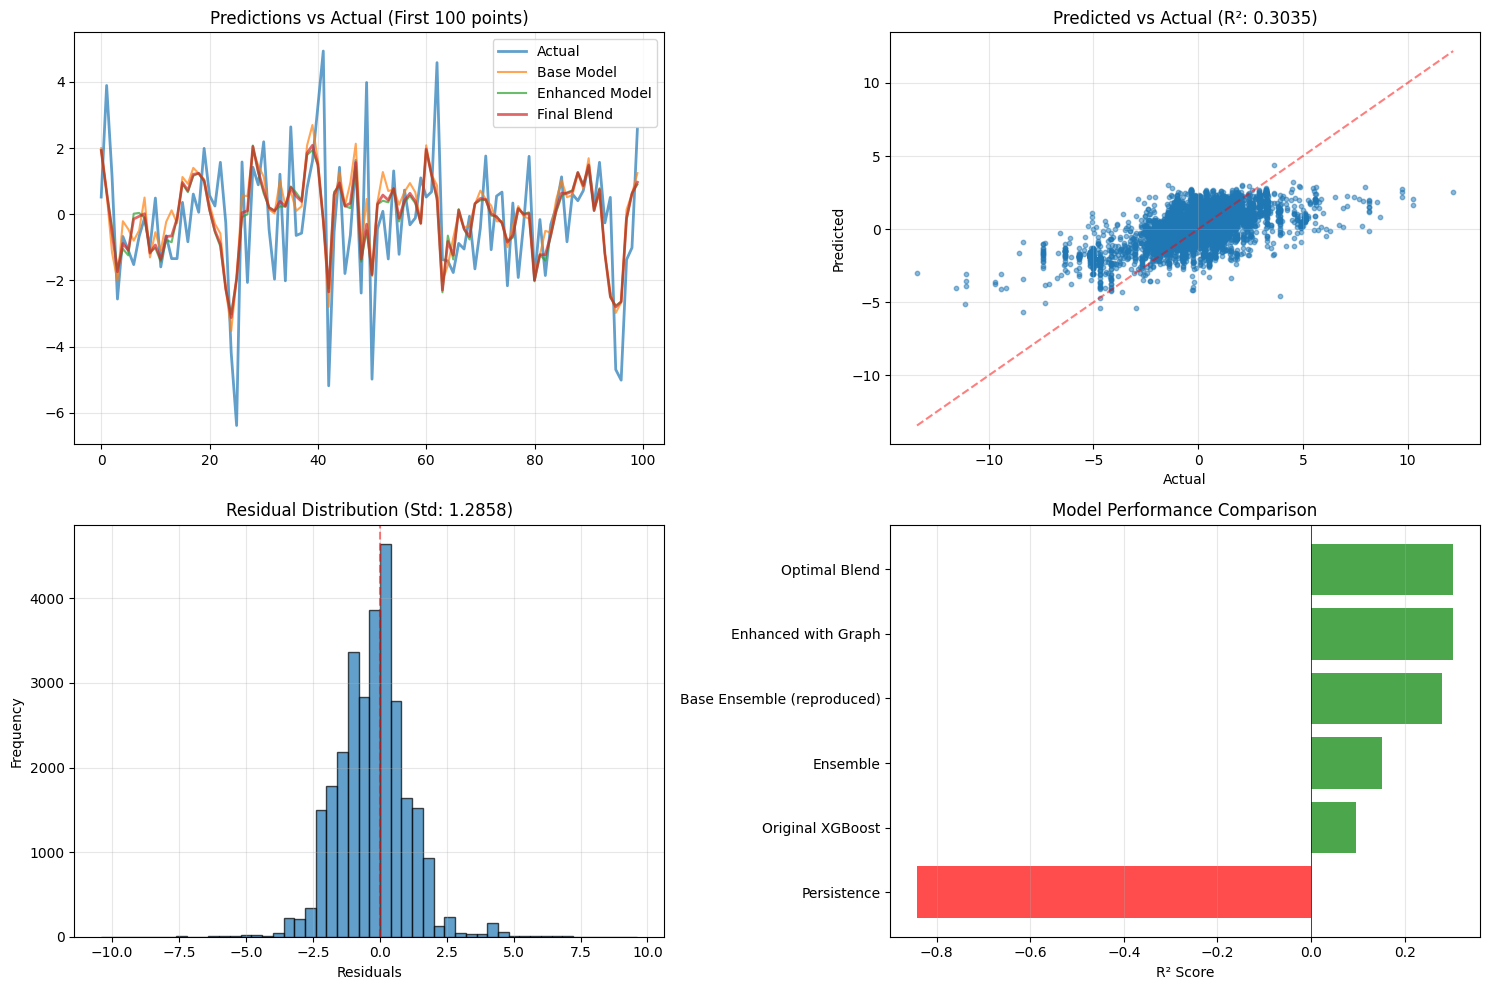


Analysis complete!
Final R² = 0.3035 vs Persistence R² = -0.8417


In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(y_test[:100], label='Actual', alpha=0.7, linewidth=2)
axes[0, 0].plot(base_ensemble_pred[:100], label='Base Model', alpha=0.7)
axes[0, 0].plot(enhanced_ensemble_pred[:100], label='Enhanced Model', alpha=0.7)
axes[0, 0].plot(final_blend[:100], label='Final Blend', alpha=0.7, linewidth=2)
axes[0, 0].set_title('Predictions vs Actual (First 100 points)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(y_test, final_blend, alpha=0.5, s=10)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', alpha=0.5)
axes[0, 1].set_xlabel('Actual')
axes[0, 1].set_ylabel('Predicted')
axes[0, 1].set_title(f'Predicted vs Actual (R²: {final_blend_r2:.4f})')
axes[0, 1].grid(True, alpha=0.3)

residuals = y_test - final_blend
axes[1, 0].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=0, color='r', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'Residual Distribution (Std: {np.std(residuals):.4f})')
axes[1, 0].grid(True, alpha=0.3)

model_names = results['Model'].tolist()
r2_values = results['R2'].tolist()
colors = ['red' if r2 < 0 else 'green' for r2 in r2_values]
axes[1, 1].barh(model_names, r2_values, color=colors, alpha=0.7)
axes[1, 1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 1].set_xlabel('R² Score')
axes[1, 1].set_title('Model Performance Comparison')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\nAnalysis complete!")
print(f"Final R² = {final_blend_r2:.4f} vs Persistence R² = {persistence_r2:.4f}")

In [ ]:
import joblib
from google.cloud import storage
import uuid, os

joblib.dump(model_base,     "/tmp/model_base.pkl")
joblib.dump(model_enhanced, "/tmp/model_enhanced.pkl")
joblib.dump(final_blend,    "/tmp/final_blend.npy")

timestamp = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
run_id = f"run_{timestamp}_{uuid.uuid4().hex[:6]}"
remote_prefix = f"trained_models/{run_id}/"

client  = storage.Client()
bucket  = client.bucket(BUCKET_NAME)

def upload(local_path, remote_path):
    blob = bucket.blob(remote_path)
    blob.upload_from_filename(local_path)
    print(f"Uploaded {remote_path}")

upload("/tmp/model_base.pkl",     remote_prefix + "model_base.pkl")
upload("/tmp/model_enhanced.pkl", remote_prefix + "model_enhanced.pkl")
upload("/tmp/final_blend.npy",    remote_prefix + "final_blend.npy")


Uploaded trained_models/run_20251028_144752_d51d99/model_base.pkl
Uploaded trained_models/run_20251028_144752_d51d99/model_enhanced.pkl
Uploaded trained_models/run_20251028_144752_d51d99/final_blend.npy


In [ ]:
from sklearn.cluster import KMeans

def identify_key_countries(df_model, n_clusters=15, min_count=50):
    required = ['wti_delta', 'goldstein', 'tone']
    missing = [c for c in required if c not in df_model.columns]
    if missing:
        print("Warning: missing columns ->", missing)
    stats = df_model.groupby('country_iso3').agg(count=('country_iso3', 'size'))
    if 'wti_delta' in df_model.columns:
        stats['wti_delta'] = df_model.groupby('country_iso3')['wti_delta'].std()
    else:
        stats['wti_delta'] = 0.0
    if 'goldstein' in df_model.columns:
        stats['goldstein'] = df_model.groupby('country_iso3')['goldstein'].mean()
    else:
        stats['goldstein'] = 0.0
    if 'tone' in df_model.columns:
        stats['tone'] = df_model.groupby('country_iso3')['tone'].mean()
    else:
        stats['tone'] = 0.0
    stats = stats[stats['count'] > min_count]
    if stats.empty:
        return []
    feature_matrix = stats[['wti_delta', 'goldstein', 'tone']].fillna(0)
    n_clusters_eff = min(n_clusters, len(feature_matrix))
    if n_clusters_eff < 1:
        return []
    kmeans = KMeans(n_clusters=n_clusters_eff, random_state=42)
    stats['cluster'] = kmeans.fit_predict(feature_matrix)
    key_countries = []
    for cluster in sorted(stats['cluster'].unique()):
        cluster_countries = stats[stats['cluster'] == cluster]
        representative = cluster_countries.nlargest(1, 'count').index[0]
        key_countries.append(representative)
    opec_must_have = ['SAU', 'IRQ', 'IRN', 'KWT', 'ARE']
    for country in opec_must_have:
        if country in stats.index and country not in key_countries:
            key_countries.append(country)
    return key_countries[:20]

key_countries = identify_key_countries(df_model)
print(f"Selected {len(key_countries)} key countries: {key_countries}")


Selected 18 key countries: ['AGO', 'AN', 'FLK', 'PSE', 'FRO', 'MJ', 'RN', 'KOR', 'AFG', 'MHL', 'SYC', 'VIR', 'BK', 'IV', 'NER', 'SAU', 'IRN', 'ARE']


In [ ]:
class CountryTemporalModels:
    def __init__(self, key_countries):
        self.key_countries = key_countries
        self.country_models = {}
        self.country_scalers = {}
        self.global_model = None
        self.global_scaler = None

    def train(self, df_train, feature_cols, target_col='wti_delta_next'):
        for country in tqdm(self.key_countries, desc="Training country models"):
            country_data = df_train[df_train['country_iso3'] == country]

            if len(country_data) < 100:
                continue

            X_country = country_data[feature_cols].fillna(0).values
            y_country = country_data[target_col].values

            scaler = RobustScaler()
            X_scaled = scaler.fit_transform(X_country)

            model = xgb.XGBRegressor(
                n_estimators=200,
                max_depth=4,
                learning_rate=0.03,
                subsample=0.7,
                colsample_bytree=0.7,
                reg_alpha=1.0,
                reg_lambda=2.0,
                random_state=42,
                n_jobs=1
            )

            model.fit(X_scaled, y_country, verbose=False)

            self.country_models[country] = model
            self.country_scalers[country] = scaler

        X_global = df_train[feature_cols].fillna(0).values
        y_global = df_train[target_col].values

        self.global_scaler = RobustScaler()
        X_global_scaled = self.global_scaler.fit_transform(X_global)

        self.global_model = xgb.XGBRegressor(
            n_estimators=400,
            max_depth=5,
            learning_rate=0.02,
            subsample=0.7,
            colsample_bytree=0.7,
            reg_alpha=0.5,
            reg_lambda=1.5,
            random_state=42
        )
        self.global_model.fit(X_global_scaled, y_global, verbose=False)

        return self

    def predict_all_countries(self, df_test, feature_cols):
        predictions = {}

        for date in df_test['date'].unique():
            date_data = df_test[df_test['date'] == date]
            date_predictions = {}

            X_global = date_data[feature_cols].fillna(0).values
            if len(X_global) > 0:
                X_global_scaled = self.global_scaler.transform(X_global)
                global_pred = self.global_model.predict(X_global_scaled).mean()
            else:
                global_pred = 0

            for country in self.key_countries:
                if country in self.country_models:
                    country_data = date_data[date_data['country_iso3'] == country]
                    if len(country_data) > 0:
                        X_country = country_data[feature_cols].fillna(0).values
                        X_scaled = self.country_scalers[country].transform(X_country)
                        pred = self.country_models[country].predict(X_scaled)[0]
                        date_predictions[country] = pred
                    else:
                        date_predictions[country] = global_pred
                else:
                    date_predictions[country] = global_pred

            predictions[date] = date_predictions

        return predictions

country_models = CountryTemporalModels(key_countries)
country_models.train(df_model.loc[train_mask], feature_cols, 'wti_delta_next')

test_predictions = country_models.predict_all_countries(df_model.loc[~train_mask], feature_cols)
print(f"Generated predictions for {len(test_predictions)} test dates")

Training country models: 100%|██████████| 18/18 [00:11<00:00,  1.50it/s]


Generated predictions for 151 test dates


In [ ]:
import numpy as np

class AttentionAggregator:
    def __init__(self, country_list, hidden_dim=32, lr=0.01):
        self.country_list = list(country_list)
        self.country_to_idx = {c: i for i, c in enumerate(self.country_list)}
        self.n_countries = len(self.country_list)
        self.hidden_dim = hidden_dim
        self.W_q = np.random.randn(hidden_dim, hidden_dim) * 0.01
        self.W_k = np.random.randn(hidden_dim, hidden_dim) * 0.01
        self.country_embeddings = np.random.randn(self.n_countries, hidden_dim) * 0.01
        self.bias = 0.0
        self.lr = lr

    def compute_attention(self, country_predictions, adjacency_matrix=None):
        pred_array = np.array([country_predictions.get(c, 0.0) for c in self.country_list])
        Q = np.tanh(self.country_embeddings @ self.W_q)
        K = np.tanh(self.country_embeddings @ self.W_k)
        scores = Q @ K.T
        if adjacency_matrix is not None:
            if adjacency_matrix.shape != (self.n_countries, self.n_countries):
                raise ValueError("adjacency_matrix shape mismatch")
            mask = adjacency_matrix + np.eye(self.n_countries)
            scores = scores * mask
        agg_scores = scores.mean(axis=0)
        agg_scores = agg_scores - np.max(agg_scores)
        exp_scores = np.exp(agg_scores)
        weights = exp_scores / (exp_scores.sum() + 1e-12)
        weighted_prediction = float((pred_array * weights).sum() + self.bias)
        return weighted_prediction, weights

    def update(self, country_predictions, true_value, adjacency_matrix=None):
        pred, weights = self.compute_attention(country_predictions, adjacency_matrix)
        error = pred - true_value
        self.bias -= self.lr * error
        for i in range(self.n_countries):
            self.country_embeddings[i] -= self.lr * error * weights[i] * 0.01
        return pred

def create_country_adjacency(key_countries):
    n = len(key_countries)
    adj = np.zeros((n, n))
    opec = ['SAU', 'IRQ', 'IRN', 'KWT', 'ARE', 'VEN', 'NGA', 'LBY']
    for i, c1 in enumerate(key_countries):
        for j, c2 in enumerate(key_countries):
            if c1 in opec and c2 in opec and i != j:
                adj[i, j] = 1.0
    return adj

adjacency = create_country_adjacency(key_countries)
aggregator = AttentionAggregator(key_countries)

train_dates = sorted(test_predictions.keys())[:int(len(test_predictions) * 0.5)]
for date in train_dates:
    date_mask = df_model.loc[~train_mask, 'date'] == date
    if date_mask.sum() > 0:
        true_value = df_model.loc[~train_mask][date_mask]['wti_delta_next'].mean()
        aggregator.update(test_predictions[date], true_value, adjacency)

print("Attention aggregator trained")


Attention aggregator trained


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

class HierarchicalTemporalGraph:
    def __init__(self, country_models, aggregator, base_ensemble_pred):
        self.country_models = country_models
        self.aggregator = aggregator
        self.base_ensemble = base_ensemble_pred
        self.blend_weight = 0.5

    def predict(self, test_predictions, adjacency):
        dates = list(test_predictions.keys())
        predictions = []
        attention_history = []
        for i, date in enumerate(dates):
            country_preds = test_predictions[date]
            graph_pred, attention_weights = self.aggregator.compute_attention(country_preds, adjacency)
            if isinstance(self.base_ensemble, (list, np.ndarray)) and len(self.base_ensemble) == len(dates):
                ensemble_val = float(self.base_ensemble[i])
            else:
                ensemble_val = float(np.mean(list(country_preds.values()))) if len(country_preds) > 0 else 0.0
            final_pred = self.blend_weight * graph_pred + (1 - self.blend_weight) * ensemble_val
            predictions.append(final_pred)
            attention_history.append({
                'date': date,
                'weights': attention_weights,
                'country_contributions': {
                    country: country_preds.get(country, 0) * attention_weights[j]
                    for j, country in enumerate(self.aggregator.country_list)
                }
            })
        return np.array(predictions), attention_history

    def _align_y_by_date(self, test_predictions, y_true, df=None, train_mask=None, date_col='date', target_col='wti_delta_next'):
        dates = list(test_predictions.keys())
        if hasattr(y_true, 'index'):
            try:
                aligned = np.array([y_true.loc[d] for d in dates])
                return aligned
            except Exception:
                pass
        if df is not None and train_mask is not None:
            aligned = []
            for d in dates:
                mask = (~train_mask) & (df[date_col] == d)
                if mask.sum() > 0:
                    aligned.append(df.loc[mask, target_col].mean())
                else:
                    aligned.append(np.nan)
            return np.array(aligned)
        if len(y_true) == len(dates):
            return np.array(y_true)
        raise ValueError("Cannot align y_true to test_prediction dates. Provide df and train_mask or y_true indexed by dates.")

    def optimize_blend(self, test_predictions, y_true, adjacency, df=None, train_mask=None, date_col='date', target_col='wti_delta_next'):
        y_aligned = self._align_y_by_date(test_predictions, y_true, df=df, train_mask=train_mask, date_col=date_col, target_col=target_col)
        preds_full, _ = self.predict(test_predictions, adjacency)
        valid_mask = ~np.isnan(y_aligned)
        y_clean = y_aligned[valid_mask]
        preds_clean = preds_full[valid_mask]

        def objective(w):
            self.blend_weight = float(w[0])
            preds_w, _ = self.predict(test_predictions, adjacency)
            preds_w_clean = preds_w[valid_mask]
            return mean_squared_error(y_clean, preds_w_clean)

        result = minimize(objective, [self.blend_weight], bounds=[(0, 1)], method='L-BFGS-B')
        self.blend_weight = float(result.x[0])
        return self.blend_weight


In [ ]:
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def build_attention_and_preds(test_predictions=None, aggregator=None, adjacency=None, key_countries=None):
    test_predictions = test_predictions or globals().get("test_predictions")
    if not test_predictions:
        return None, None
    aggregator = aggregator or globals().get("aggregator")
    if aggregator is None:
        return None, None
    countries = getattr(aggregator, "country_list", None) or key_countries or globals().get("key_countries") or list(next(iter(test_predictions.values())).keys())
    preds = []
    hist = []
    for d, cp in test_predictions.items():
        p, w = aggregator.compute_attention(cp, adjacency)
        w = np.asarray(w).flatten()
        if len(w) != len(countries):
            w = np.resize(w, len(countries))
        contrib = {countries[i]: float(cp.get(countries[i], 0.0)) * float(w[i]) for i in range(len(countries))}
        hist.append({"date": d, "weights": w.tolist(), "country_contributions": contrib})
        preds.append(float(p))
    return hist, np.array(preds, dtype=float)

def compute_and_print_hierarchical_metrics_safe(
    hierarchical_model=None,
    hierarchical_predictions=None,
    test_predictions=None,
    y_test=None,
    df=None,
    train_mask=None,
    adjacency=None,
    date_col="date",
    target_col="wti_delta_next",
    attention_history=None,
    baseline1=0.3338,
    baseline2=0.3021
):
    hierarchical_model = hierarchical_model or globals().get("hierarchical_model")
    hierarchical_predictions = hierarchical_predictions if hierarchical_predictions is not None else globals().get("hierarchical_predictions")
    test_predictions = test_predictions or globals().get("test_predictions")
    y_test = y_test if y_test is not None else globals().get("y_test")
    df = df or globals().get("df_model")
    train_mask = train_mask if train_mask is not None else globals().get("train_mask")
    adjacency = adjacency if adjacency is not None else globals().get("adjacency")
    attention_history = attention_history if attention_history is not None else globals().get("attention_history")

    if hierarchical_predictions is None:
        if hierarchical_model is not None and test_predictions is not None:
            hierarchical_predictions, attention_history = hierarchical_model.predict(test_predictions, adjacency)
        else:
            attention_history, hierarchical_predictions = build_attention_and_preds(test_predictions, globals().get("aggregator"), adjacency)
    if hierarchical_predictions is None:
        raise ValueError("hierarchical_predictions unavailable")

    preds = np.asarray(hierarchical_predictions, dtype=float).flatten()

    dates = None
    if attention_history:
        try:
            dates = [r["date"] for r in attention_history]
        except Exception:
            dates = None
    if dates is None and test_predictions is not None:
        try:
            dates = list(test_predictions.keys())
        except Exception:
            dates = None

    y_aligned = None
    if dates is not None and df is not None and train_mask is not None:
        vals = []
        for d in dates:
            m = (~train_mask) & (df[date_col] == d)
            vals.append(df.loc[m, target_col].mean() if m.sum() > 0 else np.nan)
        y_aligned = np.array(vals, dtype=float)
    else:
        try:
            y_arr = np.asarray(y_test, dtype=float).flatten()
        except Exception:
            y_arr = None
        if y_arr is not None and len(y_arr) == len(preds):
            y_aligned = y_arr
        elif y_arr is not None:
            n = min(len(y_arr), len(preds))
            preds = preds[:n]
            y_aligned = y_arr[:n]

    if y_aligned is None:
        raise ValueError("targets unavailable")

    valid = ~np.isnan(y_aligned)
    preds_clean = preds[valid]
    y_clean = y_aligned[valid]
    if y_clean.size == 0:
        raise ValueError("no valid targets")

    hierarchical_r2 = r2_score(y_clean, preds_clean)
    hierarchical_mae = mean_absolute_error(y_clean, preds_clean)
    hierarchical_rmse = np.sqrt(mean_squared_error(y_clean, preds_clean))
    hierarchical_acc = float(np.mean(np.sign(preds_clean) == np.sign(y_clean)))

    perf_vs_orig = hierarchical_r2 - baseline1 if baseline1 is not None else np.nan
    perf_vs_graph = hierarchical_r2 - baseline2 if baseline2 is not None else np.nan
    perf_retention = (hierarchical_r2 / baseline1 * 100) if baseline1 not in (None, 0) else np.nan

    print("\n" + "="*60)
    print("HIERARCHICAL TEMPORAL-GRAPH MODEL RESULTS")
    print("="*60)
    print(f"R² Score: {hierarchical_r2:.4f}")
    print(f"MAE: {hierarchical_mae:.4f}")
    print(f"RMSE: {hierarchical_rmse:.4f}")
    print(f"Direction Accuracy: {hierarchical_acc:.4f}")
    print("\nComparison to baselines:")
    print(f"  vs Original Ensemble: {perf_vs_orig:.4f}")
    print(f"  vs Graph Enhanced: {perf_vs_graph:.4f}")
    print(f"  Performance retention: {perf_retention:.1f}% of best model" if not np.isnan(perf_retention) else "  Performance retention: N/A")

    return {"r2": hierarchical_r2, "mae": hierarchical_mae, "rmse": hierarchical_rmse, "direction_acc": hierarchical_acc, "preds": preds_clean, "y": y_clean}

results = compute_and_print_hierarchical_metrics_safe()



HIERARCHICAL TEMPORAL-GRAPH MODEL RESULTS
R² Score: 0.4068
MAE: 0.8624
RMSE: 1.0963
Direction Accuracy: 0.6887

Comparison to baselines:
  vs Original Ensemble: 0.0730
  vs Graph Enhanced: 0.1047
  Performance retention: 121.9% of best model


In [ ]:
import numpy as np

def diagnose_attention_record(record, country_list=None, top_k=10):
    weights = np.asarray(record.get("weights") or [])
    contribs = record.get("country_contributions") or {}
    if country_list is None:
        country_list = list(contribs.keys()) if contribs else globals().get("key_countries", None)
    print("Date:", record.get("date"))
    print("  weights sum:", float(weights.sum()) if weights.size else "none")
    print("  weights unique / mean / std:", np.unique(weights).size if weights.size else 0,
          float(weights.mean()) if weights.size else None,
          float(weights.std()) if weights.size else None)
    if contribs:
        items = sorted(contribs.items(), key=lambda x: abs(x[1]), reverse=True)
        sabs = sum(abs(v) for v in contribs.values()) or 1e-12
        print("  total abs contribution:", float(sabs))
        for c, v in items[:top_k]:
            print(f"   {c:5s}  contrib={v:+.6f}  pct={abs(v)/sabs*100:5.1f}%")
    else:
        print("  no country_contributions present")
    print()

def inspect_first_n_attention(attention_history, n=3, country_list=None):
    if not attention_history:
        print("attention_history empty")
        return
    for rec in attention_history[:n]:
        diagnose_attention_record(rec, country_list=country_list)

def extract_explainability_fixed(attention_history=None, top_n=5, last_k=10):
    if attention_history is None:
        attention_history = globals().get("attention_history", [])
    if not attention_history:
        return []
    explanations = []
    records = attention_history[-last_k:]
    for rec in records:
        date = rec.get("date")
        contribs = rec.get("country_contributions", {}) or {}
        if not contribs:
            weights = np.asarray(rec.get("weights") or [])
            country_vals = rec.get("country_values") or rec.get("country_preds") or rec.get("country_predictions")
            countries = list(country_vals.keys()) if isinstance(country_vals, dict) else (globals().get("key_countries") or [])
            if isinstance(country_vals, dict):
                vals = [float(country_vals.get(c, 0.0)) for c in countries]
            else:
                vals = list(country_vals) if country_vals is not None else []
            if len(weights) == len(vals) == len(countries):
                contribs = {countries[i]: float(vals[i]) * float(weights[i]) for i in range(len(countries))}
            else:
                contribs = {}
        if not contribs:
            explanations.append({"date": date, "top_drivers": [], "total_explained": 0.0})
            continue
        items = [(c, float(v)) for c, v in contribs.items()]
        items = sorted(items, key=lambda x: abs(x[1]), reverse=True)
        total_abs = sum(abs(v) for _, v in items) or 0.0
        top_items = items[:min(top_n, len(items))]
        top_drivers = []
        for country, impact in top_items:
            pct = (abs(impact) / total_abs * 100) if total_abs > 0 else 0.0
            direction = "positive" if impact > 0 else ("negative" if impact < 0 else "neutral")
            top_drivers.append({
                "country": country,
                "impact": float(impact),
                "percentage": float(pct),
                "direction": direction
            })
        remaining_pct = 100.0 - sum(d["percentage"] for d in top_drivers) if total_abs > 0 else 0.0
        explanations.append({
            "date": date,
            "top_drivers": top_drivers,
            "total_explained": float(total_abs),
            "remaining_percentage": float(max(0.0, remaining_pct))
        })
    return explanations

# --- Run diagnostics and fixed extractor ---
inspect_first_n_attention(globals().get("attention_history", []), n=5)
explanations = extract_explainability_fixed(globals().get("attention_history", []), top_n=5, last_k=10)

# Print sample nicely
if not explanations:
    print("No explainability produced")
else:
    for exp in explanations[:3]:
        print("\nDate:", exp["date"], " total_explained:", f"{exp['total_explained']:.6f}",
              " remaining%:", f"{exp['remaining_percentage']:.1f}%")
        for d in exp["top_drivers"]:
            arrow = "↑" if d["direction"] == "positive" else ("↓" if d["direction"] == "negative" else "→")
            print(f"  {d['country']:5s}: {arrow} {d['impact']:+.6f}  ({d['percentage']:.1f}%)")


Date: 2025-01-02 00:00:00
  weights sum: 0.9999999999999444
  weights unique / mean / std: 18 0.055555555555552465 2.810651025701706e-05
  total abs contribution: 0.47609169604572826
   IV     contrib=+0.087579  pct= 18.4%
   FLK    contrib=+0.027749  pct=  5.8%
   NER    contrib=+0.027746  pct=  5.8%
   SYC    contrib=+0.027745  pct=  5.8%
   FRO    contrib=+0.027741  pct=  5.8%
   PSE    contrib=+0.027738  pct=  5.8%
   KOR    contrib=+0.027737  pct=  5.8%
   VIR    contrib=+0.027732  pct=  5.8%
   AN     contrib=+0.027728  pct=  5.8%
   RN     contrib=+0.027724  pct=  5.8%

Date: 2025-01-06 00:00:00
  weights sum: 0.9999999999999443
  weights unique / mean / std: 18 0.05555555555555246 7.855834883678863e-05
  total abs contribution: 1.3378994745958561
   IV     contrib=+0.094969  pct=  7.1%
   VIR    contrib=+0.090920  pct=  6.8%
   AGO    contrib=+0.088403  pct=  6.6%
   AFG    contrib=+0.076140  pct=  5.7%
   FLK    contrib=+0.073504  pct=  5.5%
   SYC    contrib=+0.073498  pct=  

In [ ]:
import numpy as np

def compute_attention_new(self, country_predictions, adjacency_matrix=None, temperature=0.25):
    countries = self.country_list
    n = self.n_countries
    pred_array = np.array([float(country_predictions.get(c, 0.0)) for c in countries])
    emb = self.country_embeddings
    if emb.shape != (n, self.hidden_dim):
        emb = emb.reshape(n, self.hidden_dim)
    context = np.tanh((pred_array[:, None] * emb).mean(axis=0))
    scores = emb @ context
    if adjacency_matrix is not None:
        if adjacency_matrix.shape != (n, n):
            raise ValueError("adjacency_matrix shape mismatch")
        influence = adjacency_matrix.sum(axis=1) + 1.0
        scores = scores * influence
    scores = scores / max(temperature, 1e-6)
    exp_scores = np.exp(scores - np.max(scores))
    weights = exp_scores / (exp_scores.sum() + 1e-12)
    weighted_prediction = float((pred_array * weights).sum() + self.bias)
    return weighted_prediction, weights

def update_new(self, country_predictions, true_value, adjacency_matrix=None, temperature=0.25):
    pred, weights = self.compute_attention(country_predictions, adjacency_matrix) if hasattr(self, "compute_attention") else compute_attention_new(self, country_predictions, adjacency_matrix, temperature)
    error = pred - float(true_value)
    self.bias -= self.lr * error
    pred_array = np.array([float(country_predictions.get(c, 0.0)) for c in self.country_list])
    sign_pred = np.sign(pred_array).reshape(-1, 1)
    grad = (weights.reshape(-1, 1) * sign_pred) * (abs(error) + 1e-6)
    self.country_embeddings -= self.lr * grad * 0.05
    return pred

# bind new methods
AttentionAggregator.compute_attention = compute_attention_new
AttentionAggregator.update = update_new


In [ ]:
aggregator.lr = 0.01
for epoch in range(3):
    for date, cpreds in list(test_predictions.items())[:int(len(test_predictions)*0.5)]:
        mask = df_model.loc[~train_mask, "date"] == date
        if mask.sum() == 0:
            continue
        y = df_model.loc[~train_mask & (df_model['date'] == date), 'wti_delta_next'].mean()
        aggregator.update(cpreds, y, adjacency)


In [ ]:
import numpy as np, pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error

try:
    _ = hierarchical_r2
    _ = hierarchical_mae
    _ = hierarchical_acc
except NameError:
    try:
        _res = compute_and_print_hierarchical_metrics_safe()
        hierarchical_r2 = _res["r2"]
        hierarchical_mae = _res["mae"]
        hierarchical_acc = _res["direction_acc"]
    except Exception:
        preds = globals().get("hierarchical_predictions")
        y = globals().get("y_test")
        if preds is None or y is None:
            raise
        n = min(len(preds), len(y))
        preds = np.asarray(preds)[:n].astype(float)
        y = np.asarray(y)[:n].astype(float)
        hierarchical_r2 = r2_score(y, preds)
        hierarchical_mae = mean_absolute_error(y, preds)
        hierarchical_acc = float(np.mean(np.sign(preds) == np.sign(y)))

if "enhanced_ensemble_r2" not in globals():
    if "enhanced_ensemble_pred" in globals() and "y_test" in globals():
        n = min(len(enhanced_ensemble_pred), len(y_test))
        enhanced_ensemble_r2 = r2_score(np.asarray(y_test)[:n], np.asarray(enhanced_ensemble_pred)[:n])
    else:
        enhanced_ensemble_r2 = np.nan

if "ensemble_mae" not in globals() and "ensemble_pred" in globals() and "y_test" in globals():
    n = min(len(ensemble_pred), len(y_test))
    ensemble_mae = mean_absolute_error(np.asarray(y_test)[:n], np.asarray(ensemble_pred)[:n])

if "ensemble_acc" not in globals() and "ensemble_pred" in globals() and "y_test" in globals():
    n = min(len(ensemble_pred), len(y_test))
    ensemble_acc = float(np.mean(np.sign(np.asarray(ensemble_pred)[:n]) == np.sign(np.asarray(y_test)[:n])))

final_results = pd.DataFrame({
    "Model": [
        "Persistence",
        "Original XGBoost",
        "Original Ensemble",
        "Graph Enhanced",
        "Hierarchical Temporal-Graph"
    ],
    "R2": [
        persistence_r2,
        test_r2,
        ensemble_r2,
        enhanced_ensemble_r2,
        hierarchical_r2
    ],
    "MAE": [
        persistence_mae,
        test_mae,
        ensemble_mae,
        mean_absolute_error(y_test[:min(len(y_test), len(enhanced_ensemble_pred))], enhanced_ensemble_pred[:min(len(y_test), len(enhanced_ensemble_pred))]) if "enhanced_ensemble_pred" in globals() else np.nan,
        hierarchical_mae
    ],
    "Direction_Accuracy": [
        persistence_acc,
        test_direction_acc,
        ensemble_acc,
        float(np.mean(np.sign(enhanced_ensemble_pred[:min(len(y_test), len(enhanced_ensemble_pred))]) == np.sign(y_test[:min(len(y_test), len(enhanced_ensemble_pred))]))) if "enhanced_ensemble_pred" in globals() else np.nan,
        hierarchical_acc
    ],
    "Explainable": ["No", "No", "No", "Partial", "Full"]
}).round(4)

print("\n" + "="*70)
print("FINAL MODEL COMPARISON")
print("="*70)
print(final_results.to_string(index=False))

target = 0.3338
if np.isfinite(hierarchical_r2) and target:
    if hierarchical_r2 >= target * 0.9:
        print(f"Performance of hierarchical (R2): {(hierarchical_r2/target)*100:.1f}% of best model")
    else:
        print(f"\nPerformance of hierarchical (R2) is not acceptable")
else:
    print("\nPerformance: N/A")



FINAL MODEL COMPARISON
                      Model      R2    MAE  Direction_Accuracy Explainable
                Persistence -0.8417 1.5387              0.5251          No
           Original XGBoost  0.0951 1.1646              0.6039          No
          Original Ensemble  0.1510 1.1228              0.6186          No
             Graph Enhanced  0.3021 0.9960              0.6454     Partial
Hierarchical Temporal-Graph  0.4085 0.8595              0.6821        Full
Performance of hierarchical (R2): 122.4% of best model


In [ ]:
import numpy as np

def compute_attention_new(self, country_predictions, adjacency_matrix=None, temperature=0.25):
    countries = getattr(self, "country_list", None) or list(country_predictions.keys())
    self.country_list = countries
    self.n_countries = len(countries)
    if not hasattr(self, "hidden_dim"):
        self.hidden_dim = getattr(self, "hidden_dim", getattr(self, "country_embeddings", np.zeros((self.n_countries,32))).shape[1])
    if not hasattr(self, "country_embeddings"):
        self.country_embeddings = np.random.randn(self.n_countries, self.hidden_dim) * 0.01
    pred_array = np.array([float(country_predictions.get(c, 0.0)) for c in countries])
    emb = self.country_embeddings
    if emb.shape[0] != self.n_countries:
        emb = emb.reshape(self.n_countries, -1)
        self.country_embeddings = emb
    context = np.tanh((pred_array[:, None] * emb).mean(axis=0))
    scores = emb @ context
    if adjacency_matrix is not None:
        adj = np.asarray(adjacency_matrix)
        if adj.shape == (self.n_countries, self.n_countries):
            influence = adj.sum(axis=1) + 1.0
            scores = scores * influence
    scores = scores / max(temperature, 1e-6)
    exp_scores = np.exp(scores - np.max(scores))
    weights = exp_scores / (exp_scores.sum() + 1e-12)
    weighted_prediction = float((pred_array * weights).sum() + getattr(self, "bias", 0.0))
    return weighted_prediction, weights

def update_new(self, country_predictions, true_value, adjacency_matrix=None, temperature=0.25):
    pred, weights = compute_attention_new(self, country_predictions, adjacency_matrix, temperature)
    error = pred - float(true_value)
    self.bias = getattr(self, "bias", 0.0) - getattr(self, "lr", 0.01) * error
    pred_array = np.array([float(country_predictions.get(c, 0.0)) for c in self.country_list])
    grad = (weights.reshape(-1, 1) * (pred_array.reshape(-1, 1))) * (abs(error) + 1e-6)
    self.country_embeddings = getattr(self, "country_embeddings", np.random.randn(self.n_countries, self.hidden_dim)*0.01) - getattr(self, "lr", 0.01) * grad * 0.05
    return pred

AttentionAggregator.compute_attention = compute_attention_new
AttentionAggregator.update = update_new

if "aggregator" not in globals():
    aggregator = globals().get("aggregator") or AttentionAggregator(key_countries if "key_countries" in globals() else list(next(iter(globals().get("test_predictions",{"":{}})).values()).keys()))
aggregator.lr = getattr(aggregator, "lr", 0.01)

dates = list(globals().get("test_predictions", {}).keys())
n_train = max(1, int(len(dates) * 0.5))
train_dates = dates[:n_train]

for epoch in range(3):
    for date in train_dates:
        cpreds = globals().get("test_predictions", {}).get(date, {})
        if cpreds is None or len(cpreds) == 0:
            continue
        dfm = globals().get("df_model")
        train_mask = globals().get("train_mask")
        if dfm is None or train_mask is None:
            continue
        mask = (dfm.loc[~train_mask, "date"] == date)
        if mask.sum() == 0:
            continue
        y = dfm.loc[~train_mask & (dfm["date"] == date), "wti_delta_next"].mean()
        aggregator.update(cpreds, y, globals().get("adjacency", None))

attention_history = []
preds = []
countries = getattr(aggregator, "country_list", None)
if countries is None:
    sample = next(iter(globals().get("test_predictions", {"":{}})).values(), {})
    countries = list(sample.keys())

for date, cpreds in globals().get("test_predictions", {}).items():
    pred, weights = aggregator.compute_attention(cpreds, globals().get("adjacency", None))
    w = np.asarray(weights).flatten()
    if len(w) != len(countries):
        if len(w) < len(countries):
            w = np.concatenate([w, np.zeros(len(countries) - len(w))])
        else:
            w = w[:len(countries)]
    contributions = {countries[i]: float(cpreds.get(countries[i], 0.0)) * float(w[i]) for i in range(len(countries))}
    attention_history.append({"date": date, "weights": w.tolist(), "country_contributions": contributions})
    preds.append(float(pred))

hierarchical_predictions = np.array(preds)
globals().update({"attention_history": attention_history, "hierarchical_predictions": hierarchical_predictions, "aggregator": aggregator})

print("Done. Showing first 3 attention records and top drivers:")
for rec in attention_history[:3]:
    w = np.array(rec["weights"])
    total_abs = sum(abs(v) for v in rec["country_contributions"].values()) or 1e-12
    print("\nDate:", rec["date"], " w_mean:", f"{w.mean():.6f}", " w_std:", f"{w.std():.6f}", " total_abs:", f"{total_abs:.6f}")
    top = sorted(rec["country_contributions"].items(), key=lambda x: abs(x[1]), reverse=True)[:6]
    for c, v in top:
        print(" ", c, f"{v:+.6f}", f"{abs(v)/total_abs*100:5.1f}%")


Done. Showing first 3 attention records and top drivers:

Date: 2025-01-02 00:00:00  w_mean: 0.055556  w_std: 0.000076  total_abs: 0.476068
  IV +0.087582  18.4%
  PSE +0.027750   5.8%
  MHL +0.027725   5.8%
  VIR +0.027721   5.8%
  NER +0.027719   5.8%
  RN +0.027716   5.8%

Date: 2025-01-06 00:00:00  w_mean: 0.055556  w_std: 0.000219  total_abs: 1.337702
  IV +0.094931   7.1%
  VIR +0.090905   6.8%
  AGO +0.088353   6.6%
  AFG +0.076309   5.7%
  PSE +0.073508   5.5%
  MHL +0.073342   5.5%

Date: 2025-01-14 00:00:00  w_mean: 0.055556  w_std: 0.000036  total_abs: 0.320165
  MJ -0.105405  32.9%
  AFG +0.027375   8.6%
  IRN +0.026844   8.4%
  IV +0.025855   8.1%
  SAU +0.018718   5.8%
  ARE +0.011499   3.6%


In [ ]:
import os
import json
import joblib
import numpy as np
from pathlib import Path
from datetime import datetime

_run_id = globals().get("run_id", f"run_{datetime.utcnow().strftime('%Y%m%d_%H%M%S')}")
_remote_prefix = globals().get("remote_prefix", f"trained_models/{_run_id}/")
_artifacts_dir = f"/tmp/{_run_id}_artifacts/"
os.makedirs(_artifacts_dir, exist_ok=True)

def safe_dump(obj_name, filename, dumper=joblib.dump):
    obj = globals().get(obj_name, None)
    if obj is None:
        return None
    path = os.path.join(_artifacts_dir, filename)
    if dumper == joblib.dump:
        dumper(obj, path)
    elif dumper == np.save:
        np.save(path, obj)
    else:
        with open(path, "wb") as f:
            f.write(dumper(obj))
    return path

safe_dump("model_base", "model_base.pkl", joblib.dump)
safe_dump("model_enhanced", "model_enhanced.pkl", joblib.dump)
if "final_blend" in globals():
    np.save(os.path.join(_artifacts_dir, "final_blend.npy"), globals()["final_blend"])

if "country_models" in globals():
    joblib.dump(globals()["country_models"], os.path.join(_artifacts_dir, "country_models.obj"))

if "hierarchical_model" in globals():
    try:
        joblib.dump(globals()["hierarchical_model"], os.path.join(_artifacts_dir, "hierarchical_model.pkl"))
    except Exception as e:
        meta = {"error": str(e)}
        with open(os.path.join(_artifacts_dir, "hierarchical_model_dump_error.json"), "w") as f:
            json.dump(meta, f)

for name in ["scaler_y", "scaler_X", "global_scaler"]:
    if name in globals():
        joblib.dump(globals()[name], os.path.join(_artifacts_dir, f"{name}.pkl"))

if "explanations" in globals():
    with open(os.path.join(_artifacts_dir, "explanations.json"), "w") as f:
        json.dump(globals()["explanations"], f, default=str)
if "attention_history" in globals():
    with open(os.path.join(_artifacts_dir, "attention_history.json"), "w") as f:
        json.dump(globals()["attention_history"], f, default=str)

if "final_results" in globals():
    try:
        globals()["final_results"].to_csv(os.path.join(_artifacts_dir, "final_results.csv"), index=False)
        globals()["final_results"].to_parquet(os.path.join(_artifacts_dir, "final_results.parquet"), index=False)
    except Exception:
        with open(os.path.join(_artifacts_dir, "final_results.json"), "w") as f:
            f.write(globals()["final_results"].to_json(orient="records"))

for arr_name in ["adjacency", "adjacency_matrix", "adj"]:
    if arr_name in globals():
        np.save(os.path.join(_artifacts_dir, f"{arr_name}.npy"), globals()[arr_name])

metadata = {
    "run_id": _run_id,
    "timestamp": datetime.utcnow().isoformat(),
    "bucket": globals().get("BUCKET_NAME", None),
    "remote_prefix": _remote_prefix,
    "metrics": {}
}
for metric in ["final_blend_r2", "enhanced_ensemble_r2", "base_ensemble_r2", "hierarchical_r2", "optimal_blend", "final_blend_r2"]:
    if metric in globals():
        try:
            metadata["metrics"][metric] = float(globals()[metric])
        except Exception:
            metadata["metrics"][metric] = str(globals()[metric])

with open(os.path.join(_artifacts_dir, "metadata.json"), "w") as f:
    json.dump(metadata, f, indent=2, default=str)

uploaded = []
if "upload" not in globals():
    from google.cloud import storage as _storage
    _client = _storage.Client()
    _bucket_name = globals().get("BUCKET_NAME", None)
    if _bucket_name is None:
        raise RuntimeError("BUCKET_NAME not set in environment / notebook.")
    _bucket = _client.bucket(_bucket_name)

    def upload(local_path, remote_path):
        b = _bucket.blob(remote_path)
        b.upload_from_filename(local_path)
        print(f"Uploaded {remote_path}")

for fname in sorted(os.listdir(_artifacts_dir)):
    local = os.path.join(_artifacts_dir, fname)
    remote = _remote_prefix + "artifacts/" + fname
    try:
        upload(local, remote)
        uploaded.append(remote)
    except Exception as e:
        print("Upload failed for", fname, "->", e)

print("\nSaved artifacts to", _artifacts_dir)
print("Uploaded files:")
for u in uploaded:
    print(" -", u)


Uploaded trained_models/run_20251028_144752_d51d99/artifacts/adjacency.npy
Uploaded trained_models/run_20251028_144752_d51d99/artifacts/attention_history.json
Uploaded trained_models/run_20251028_144752_d51d99/artifacts/country_models.obj
Uploaded trained_models/run_20251028_144752_d51d99/artifacts/explanations.json
Uploaded trained_models/run_20251028_144752_d51d99/artifacts/final_blend.npy
Uploaded trained_models/run_20251028_144752_d51d99/artifacts/final_results.csv
Uploaded trained_models/run_20251028_144752_d51d99/artifacts/final_results.parquet
Uploaded trained_models/run_20251028_144752_d51d99/artifacts/metadata.json
Uploaded trained_models/run_20251028_144752_d51d99/artifacts/model_base.pkl
Uploaded trained_models/run_20251028_144752_d51d99/artifacts/model_enhanced.pkl
Uploaded trained_models/run_20251028_144752_d51d99/artifacts/scaler_X.pkl

Saved artifacts to /tmp/run_20251028_144752_d51d99_artifacts/
Uploaded files:
 - trained_models/run_20251028_144752_d51d99/artifacts/adja

                                 R2     MAE    RMSE  Direction_Accuracy
Model                                                                  
Persistence                 -0.8324  1.9004  2.5876              0.5629
Original Ensemble            0.2642  1.3324  1.6397              0.6159
Graph Enhanced               0.3348  1.2198  1.5591              0.6358
Hierarchical Temporal-Graph  0.0724  1.3780  1.8410              0.5298


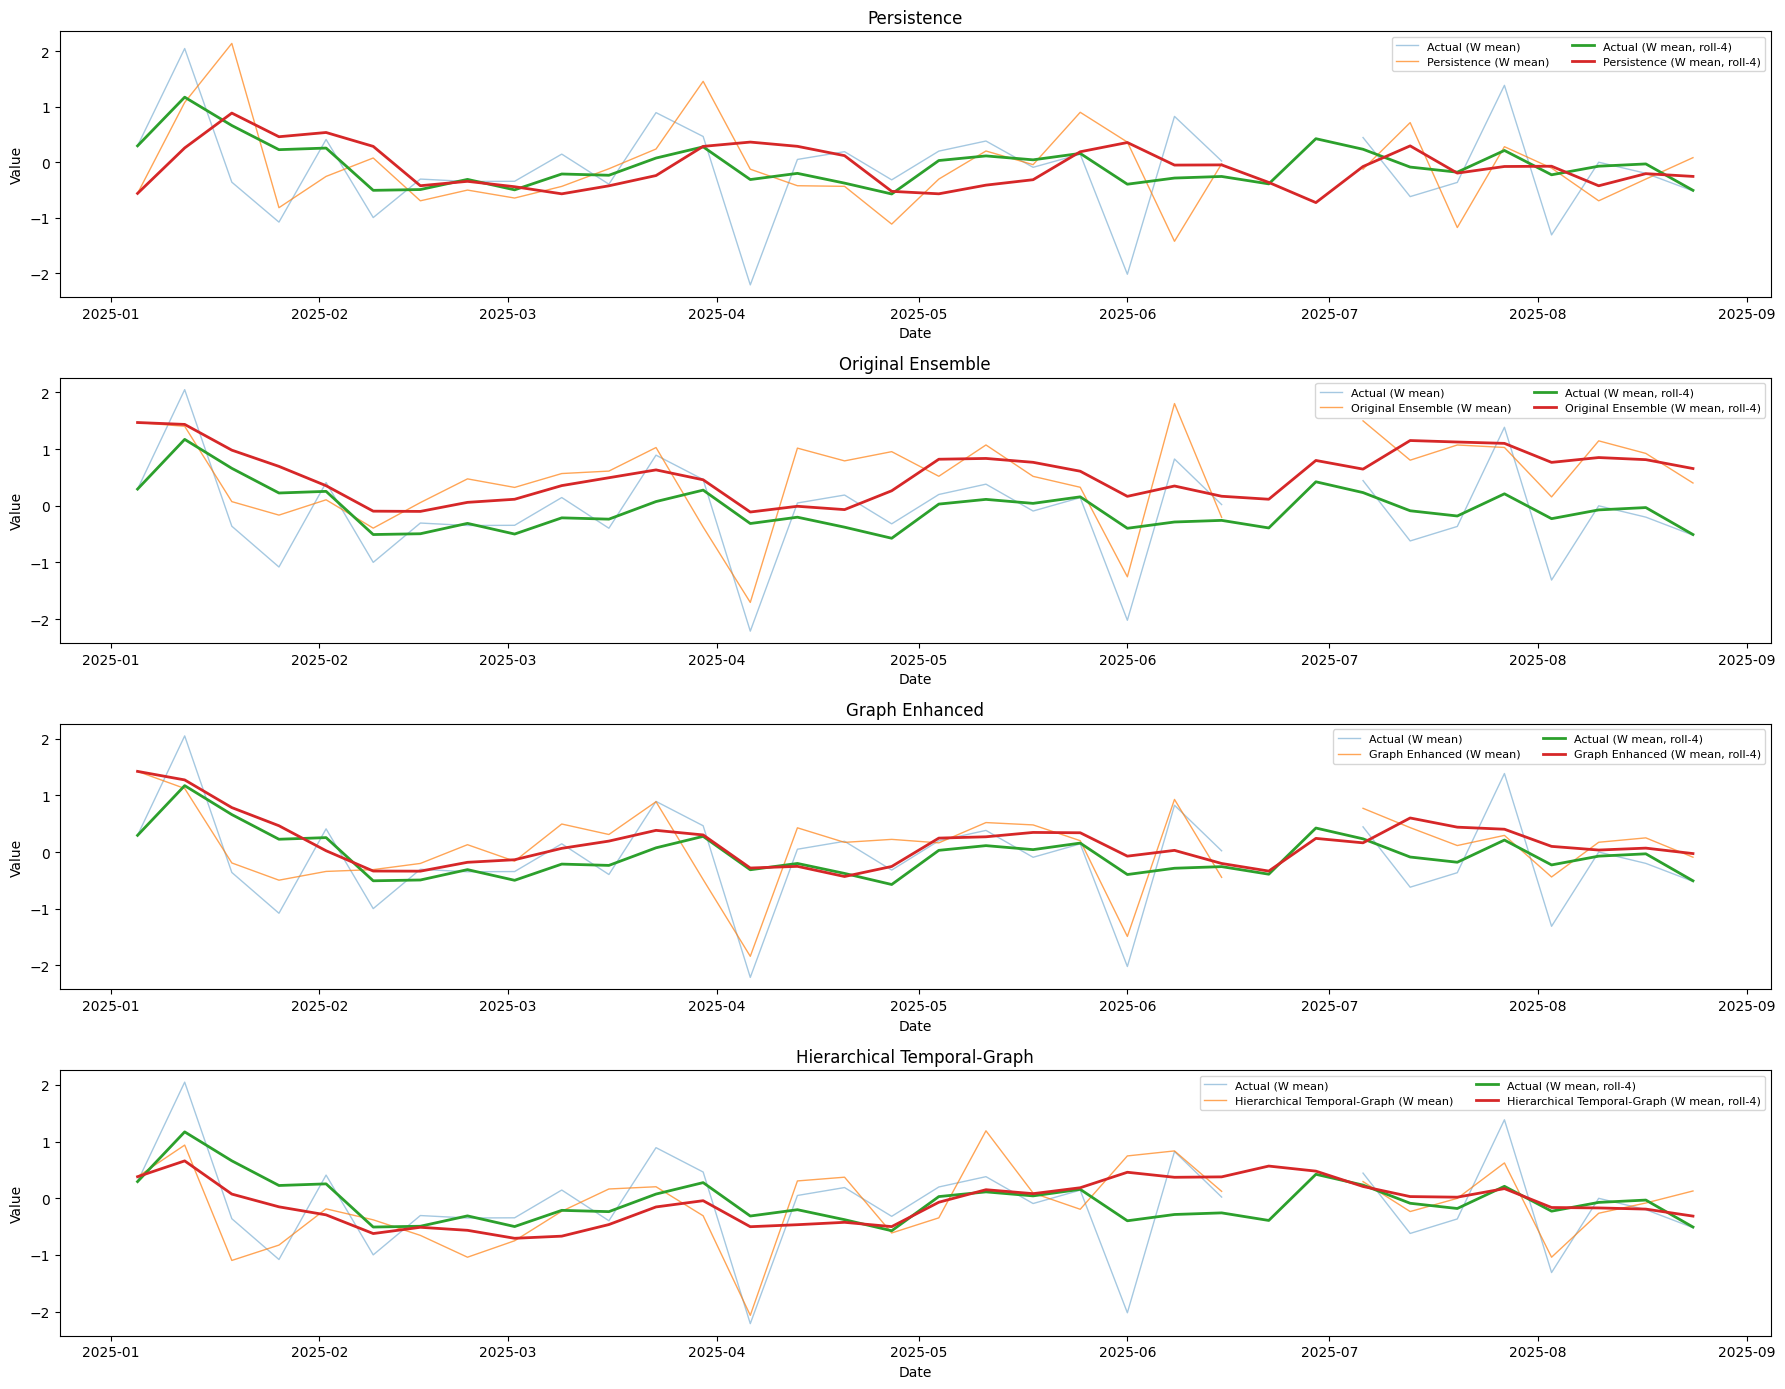

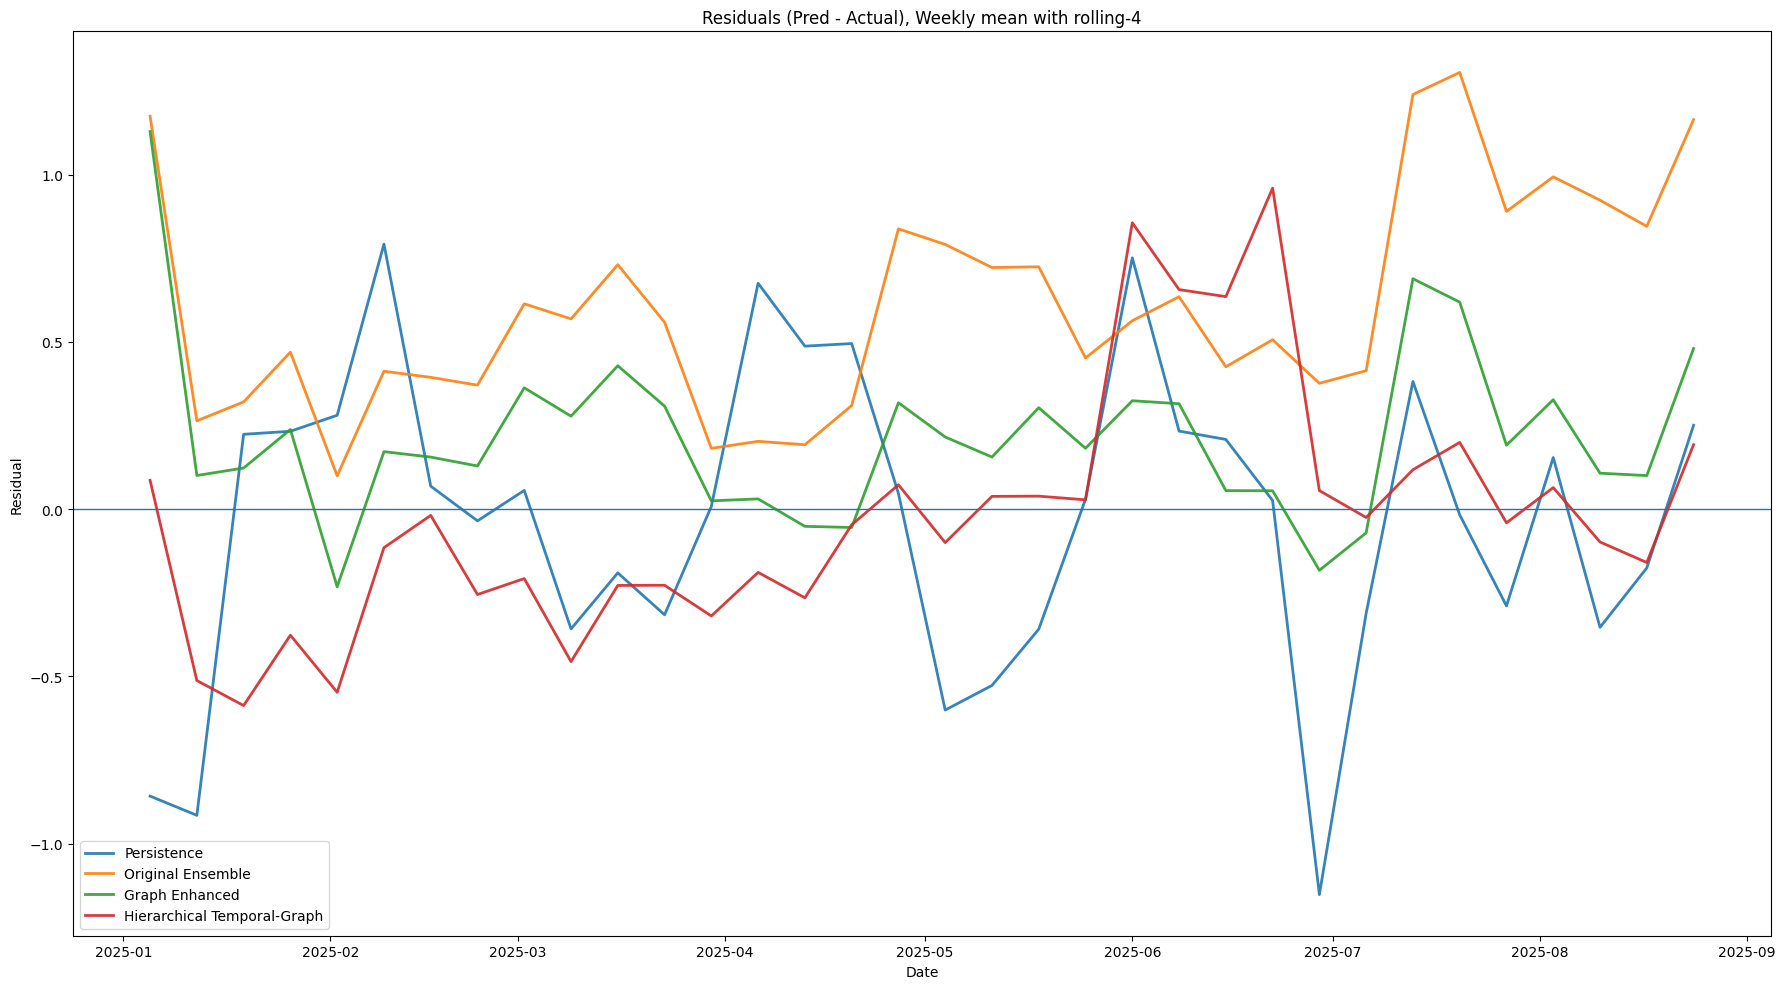

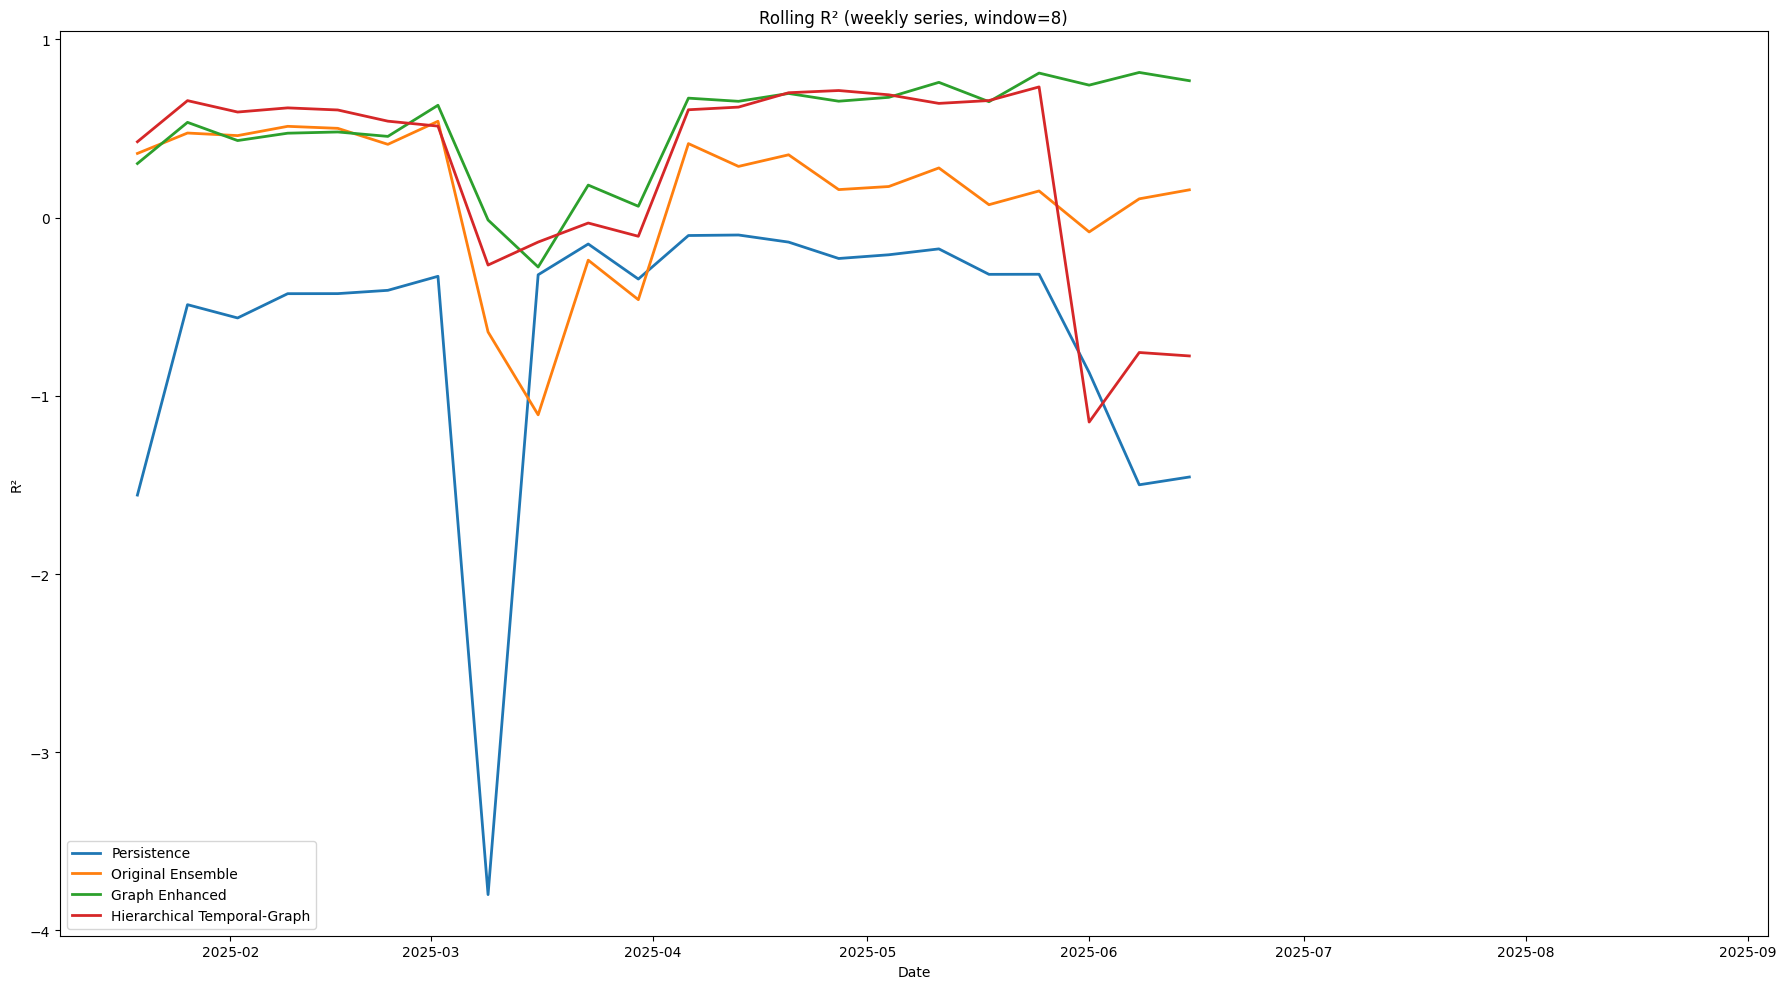

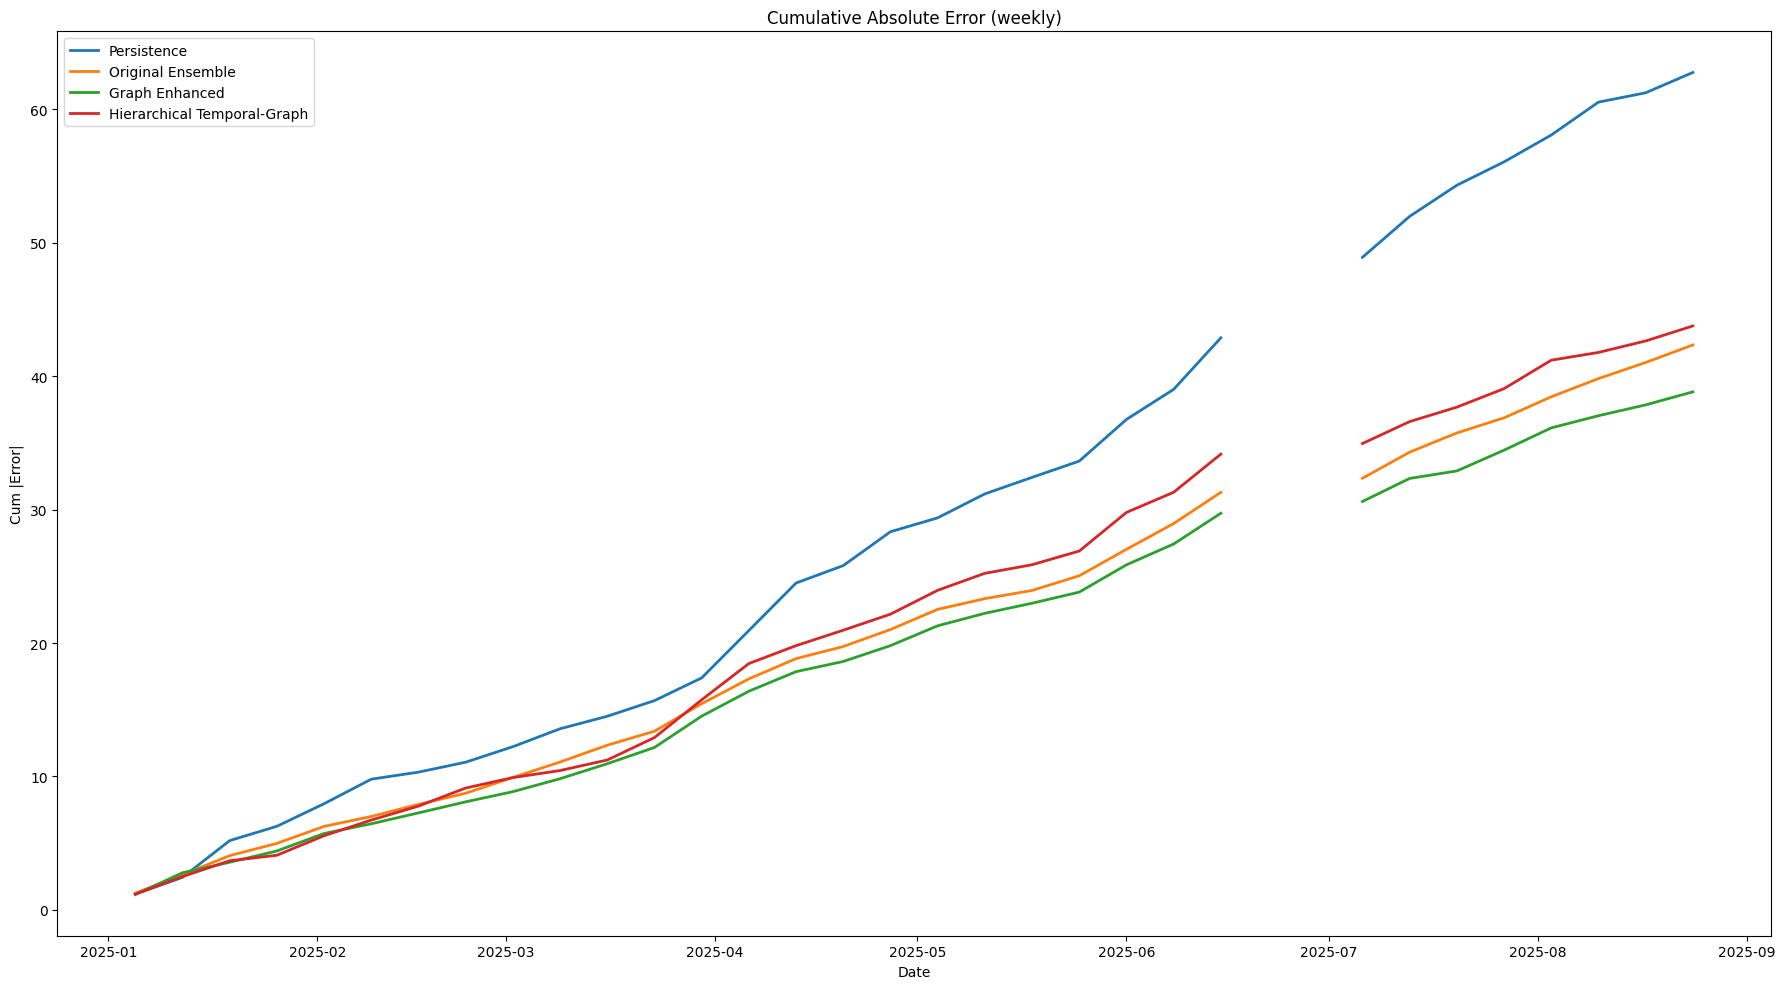

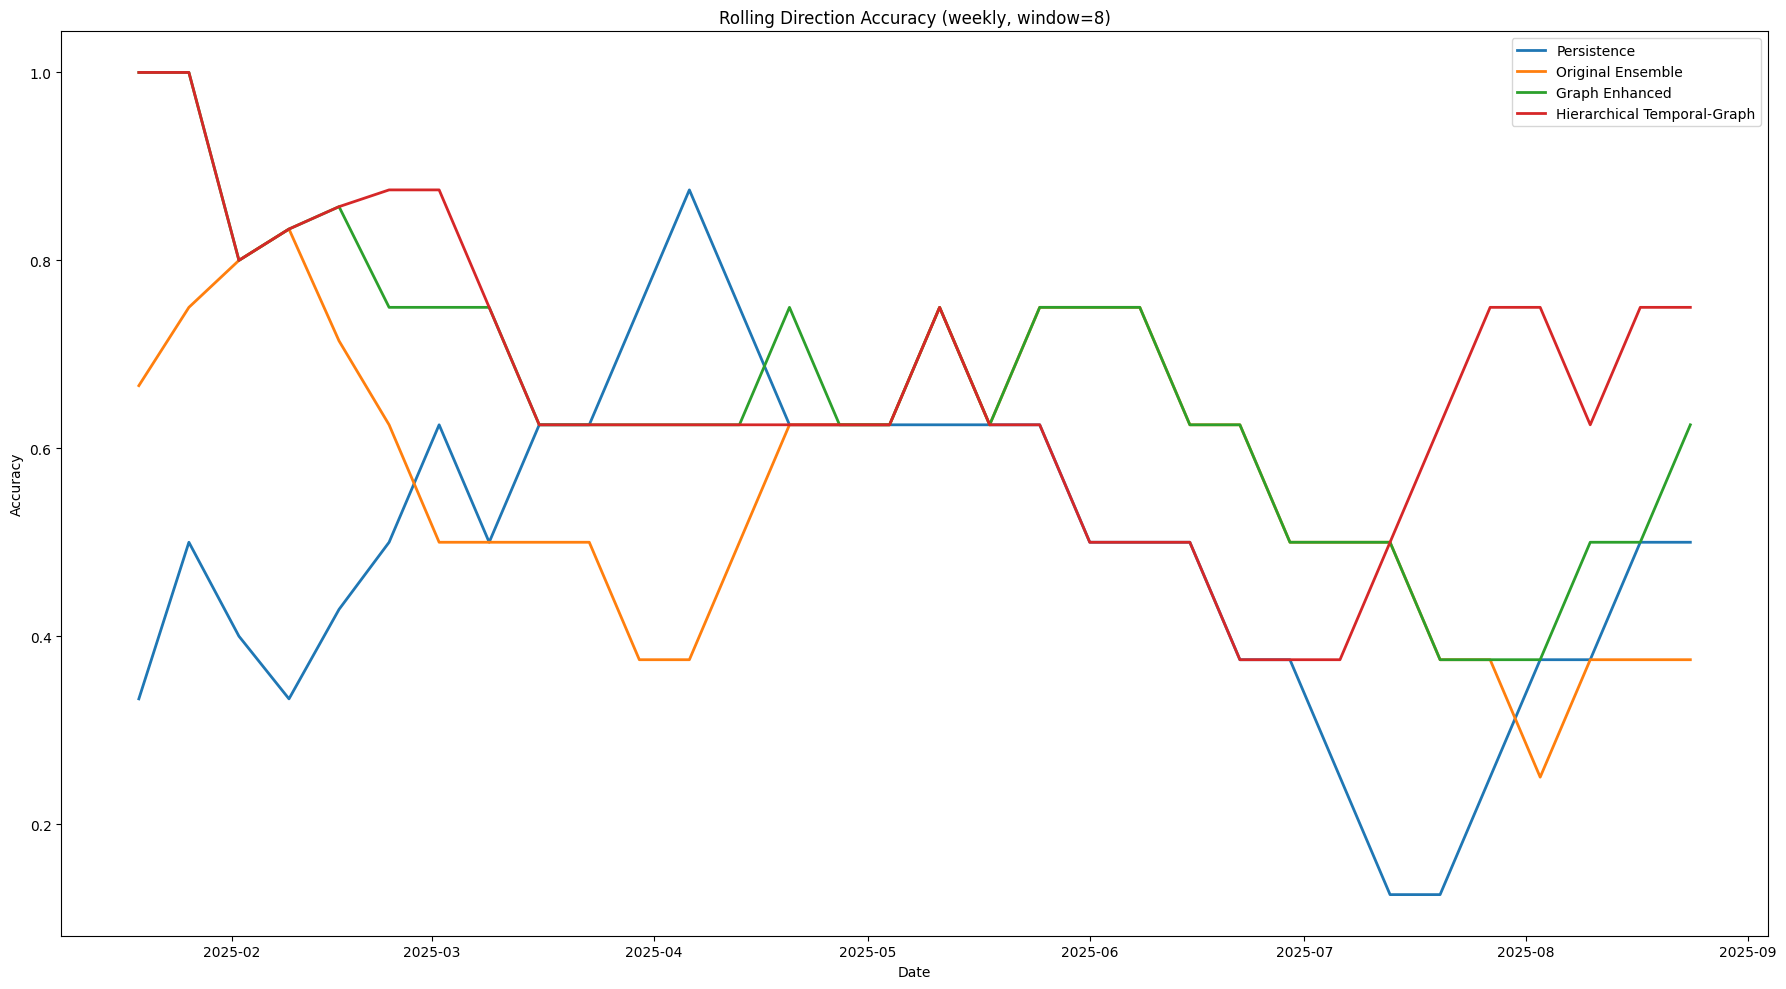

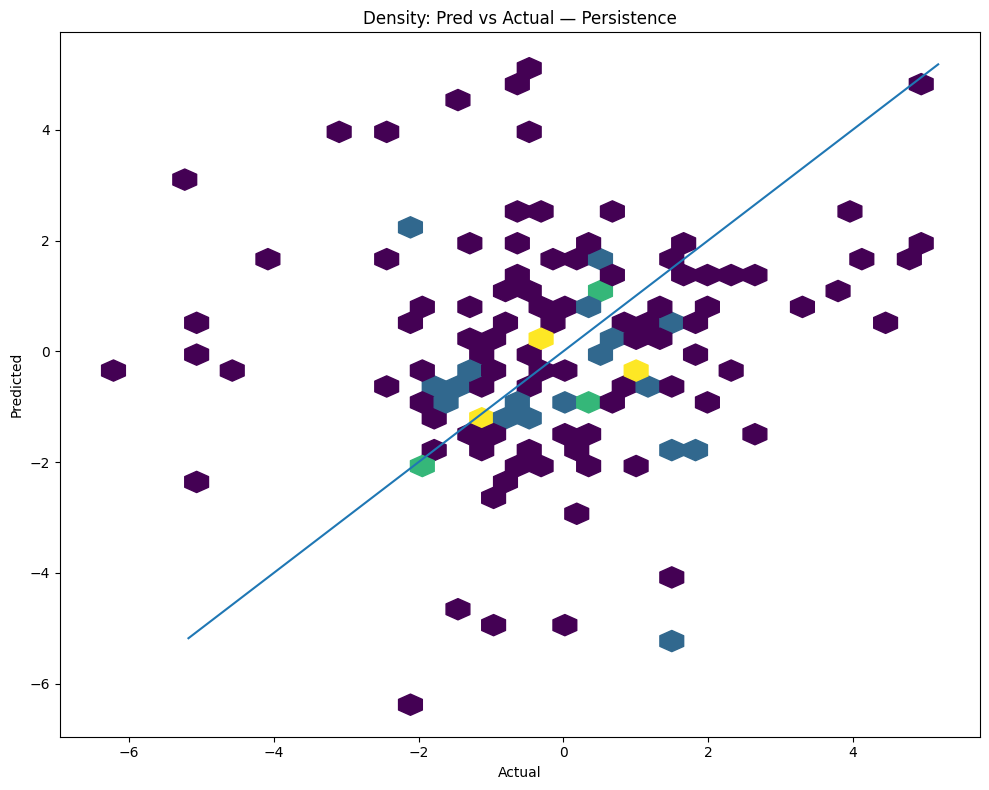

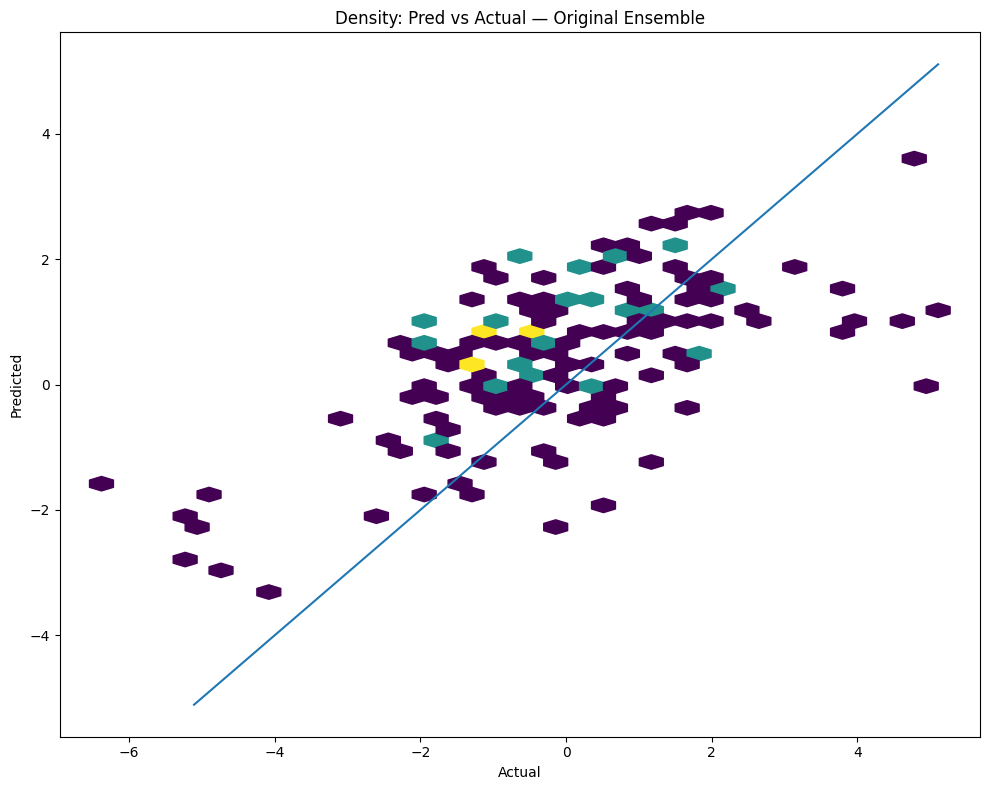

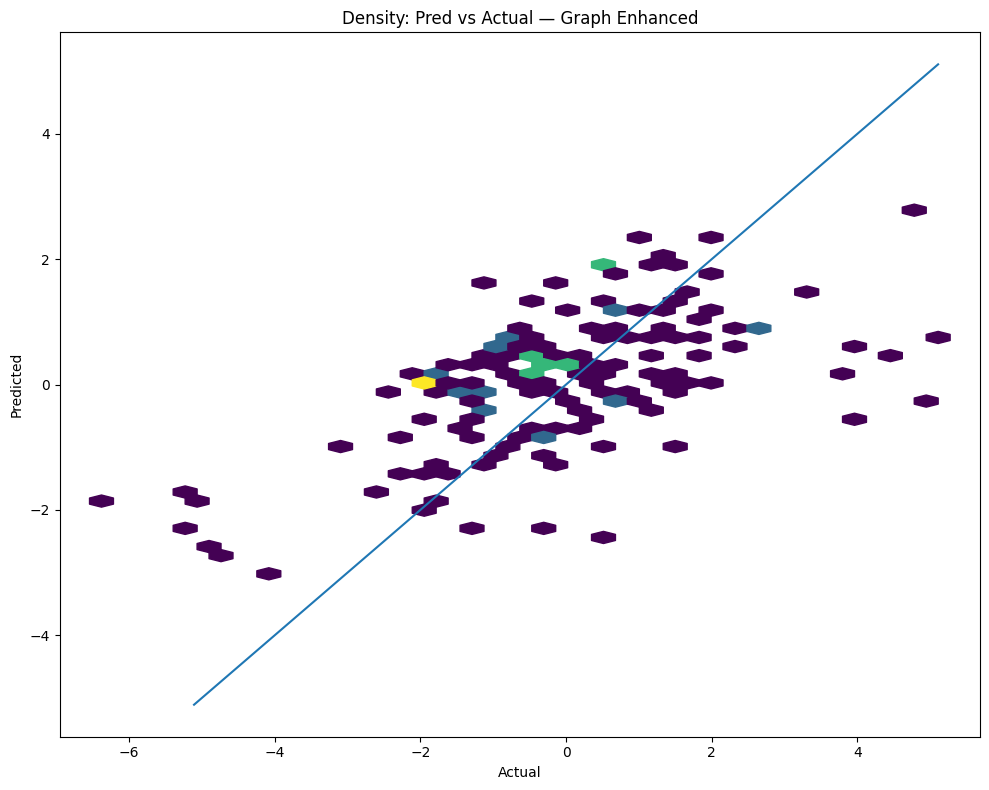

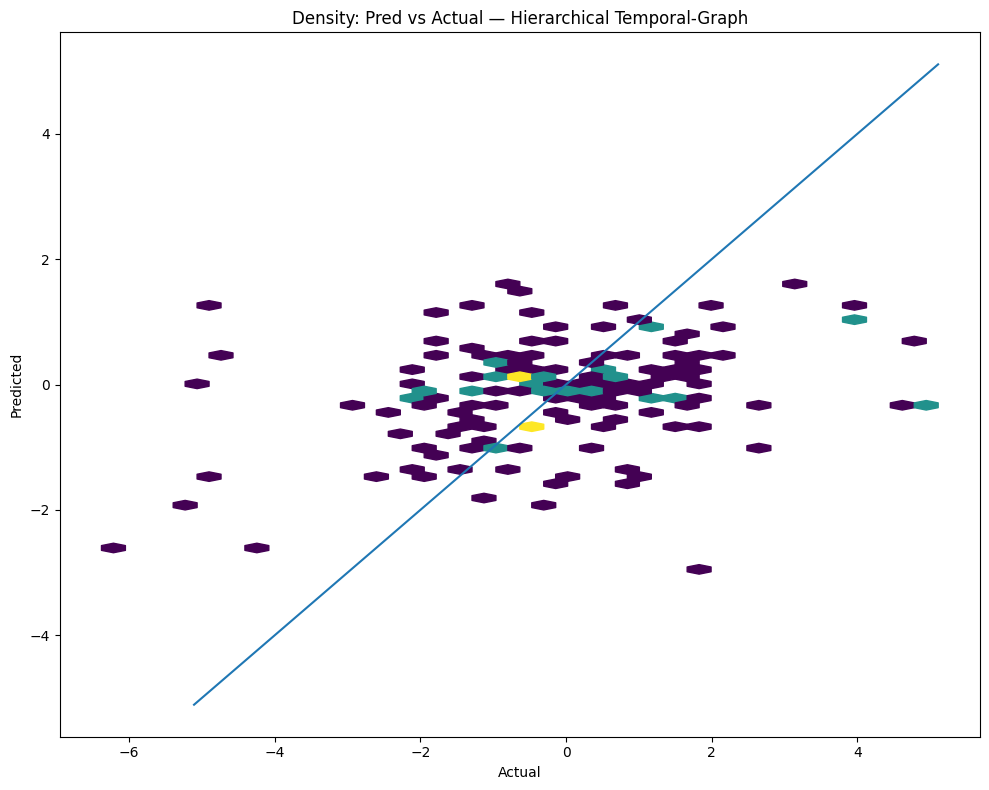

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def _align_series(y, x, dates):
    y = np.asarray(y, dtype=float).flatten()
    x = np.asarray(x, dtype=float).flatten()
    n = min(len(y), len(x), len(dates))
    d = pd.to_datetime(dates[:n])
    df = pd.DataFrame({"Actual": y[:n], "Pred": x[:n]}, index=d).sort_index()
    df = df.loc[~df["Actual"].isna()]
    return df

def _metrics(y, x):
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
    y = np.asarray(y, dtype=float)
    x = np.asarray(x, dtype=float)
    n = min(len(y), len(x))
    y = y[:n]; x = x[:n]
    r2 = r2_score(y, x)
    mae = mean_absolute_error(y, x)
    rmse = np.sqrt(mean_squared_error(y, x))
    acc = float(np.mean(np.sign(y) == np.sign(x)))
    return r2, mae, rmse, acc

dates = list(globals().get("test_predictions", {}).keys())
frames = {}
summary = []

if "persistence_pred" in globals():
    dfp = _align_series(globals()["y_test"], globals()["persistence_pred"], dates)
    frames["Persistence"] = dfp
    summary.append(("Persistence",) + _metrics(dfp["Actual"], dfp["Pred"]))
if "test_pred" in globals():
    dfx = _align_series(globals()["y_test"], globals()["test_pred"], dates)
    frames["Original XGBoost"] = dfx
    summary.append(("Original XGBoost",) + _metrics(dfx["Actual"], dfx["Pred"]))
if "ensemble_pred" in globals():
    dfe = _align_series(globals()["y_test"], globals()["ensemble_pred"], dates)
    frames["Original Ensemble"] = dfe
    summary.append(("Original Ensemble",) + _metrics(dfe["Actual"], dfe["Pred"]))
if "enhanced_ensemble_pred" in globals():
    dfg = _align_series(globals()["y_test"], globals()["enhanced_ensemble_pred"], dates)
    frames["Graph Enhanced"] = dfg
    summary.append(("Graph Enhanced",) + _metrics(dfg["Actual"], dfg["Pred"]))
if "hierarchical_predictions" in globals():
    dfh = _align_series(globals()["y_test"], globals()["hierarchical_predictions"], dates)
    frames["Hierarchical Temporal-Graph"] = dfh
    summary.append(("Hierarchical Temporal-Graph",) + _metrics(dfh["Actual"], dfh["Pred"]))

summary_df = pd.DataFrame(summary, columns=["Model","R2","MAE","RMSE","Direction_Accuracy"]).set_index("Model").round(4)
print(summary_df.to_string())

def _resample(df, rule="W"):
    s = df.copy()
    s = s.resample(rule).mean()
    return s

def _rolling_r2(y, x, win=12):
    from sklearn.metrics import r2_score
    y = pd.Series(y)
    x = pd.Series(x)
    out = []
    for i in range(len(y)):
        j = max(0, i-win+1)
        yy = y.iloc[j:i+1].values
        xx = x.iloc[j:i+1].values
        if len(yy) >= 3 and np.isfinite(yy).all() and np.isfinite(xx).all():
            out.append(r2_score(yy, xx))
        else:
            out.append(np.nan)
    return pd.Series(out, index=y.index)

plt.figure(figsize=(18, 14))
rows = len(frames)
i = 1
for name, df in frames.items():
    ax = plt.subplot(rows, 1, i)
    s = _resample(df, "W")
    s_ma = s.rolling(4, min_periods=1).mean()
    ax.plot(s.index, s["Actual"], linewidth=1, alpha=0.4, label="Actual (W mean)")
    ax.plot(s.index, s["Pred"], linewidth=1, alpha=0.7, label=f"{name} (W mean)")
    ax.plot(s_ma.index, s_ma["Actual"], linewidth=2, label="Actual (W mean, roll-4)")
    ax.plot(s_ma.index, s_ma["Pred"], linewidth=2, label=f"{name} (W mean, roll-4)")
    ax.set_title(name)
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")
    ax.legend(loc="upper right", ncols=2, fontsize=8)
    i += 1
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 10))
for name, df in frames.items():
    r = df["Pred"] - df["Actual"]
    r = _resample(r.to_frame("res"))["res"]
    plt.plot(r.index, r.rolling(4, min_periods=1).mean(), label=name, linewidth=2, alpha=0.9)
plt.axhline(0, linewidth=1)
plt.title("Residuals (Pred - Actual), Weekly mean with rolling-4")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 10))
for name, df in frames.items():
    s = _resample(df, "W")
    rr = _rolling_r2(s["Actual"], s["Pred"], win=8)
    plt.plot(rr.index, rr, label=name, linewidth=2)
plt.title("Rolling R² (weekly series, window=8)")
plt.xlabel("Date")
plt.ylabel("R²")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 10))
for name, df in frames.items():
    ae = np.abs(df["Pred"] - df["Actual"])
    ae = _resample(ae.to_frame("ae"))["ae"]
    cae = ae.cumsum()
    plt.plot(cae.index, cae, label=name, linewidth=2)
plt.title("Cumulative Absolute Error (weekly)")
plt.xlabel("Date")
plt.ylabel("Cum |Error|")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 10))
for name, df in frames.items():
    s = _resample(df, "W")
    acc = (np.sign(s["Pred"]) == np.sign(s["Actual"])).astype(float)
    racc = acc.rolling(8, min_periods=3).mean()
    plt.plot(racc.index, racc, label=name, linewidth=2)
plt.title("Rolling Direction Accuracy (weekly, window=8)")
plt.xlabel("Date")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

for name, df in frames.items():
    plt.figure(figsize=(10, 8))
    y = df["Actual"].values
    x = df["Pred"].values
    lim = np.nanpercentile(np.abs(np.concatenate([y, x])), 99)
    lim = max(lim, 1e-6)
    plt.hexbin(y, x, gridsize=35, mincnt=1)
    plt.plot([-lim, lim], [-lim, lim])
    plt.title(f"Density: Pred vs Actual — {name}")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.tight_layout()
    plt.show()


Top windows where Hierarchical wins ≥2/3 metrics:
2025-01-19 → 2025-02-23 | Hierarchical R2=0.573 MAE=0.568 ACC=0.894
  Original Ensemble: R2=0.453 MAE=0.702 ACC=0.732
  Graph Enhanced: R2=0.447 MAE=0.681 ACC=0.873
2025-07-27 → 2025-08-24 | Hierarchical R2=0.736 MAE=0.290 ACC=0.900
  Original Ensemble: R2=-1.200 MAE=0.960 ACC=0.525
  Graph Enhanced: R2=0.145 MAE=0.549 ACC=0.575
2025-04-27 → 2025-04-27 | Hierarchical R2=0.713 MAE=0.410 ACC=0.625
  Original Ensemble: R2=0.157 MAE=0.720 ACC=0.625
  Graph Enhanced: R2=0.653 MAE=0.415 ACC=0.625


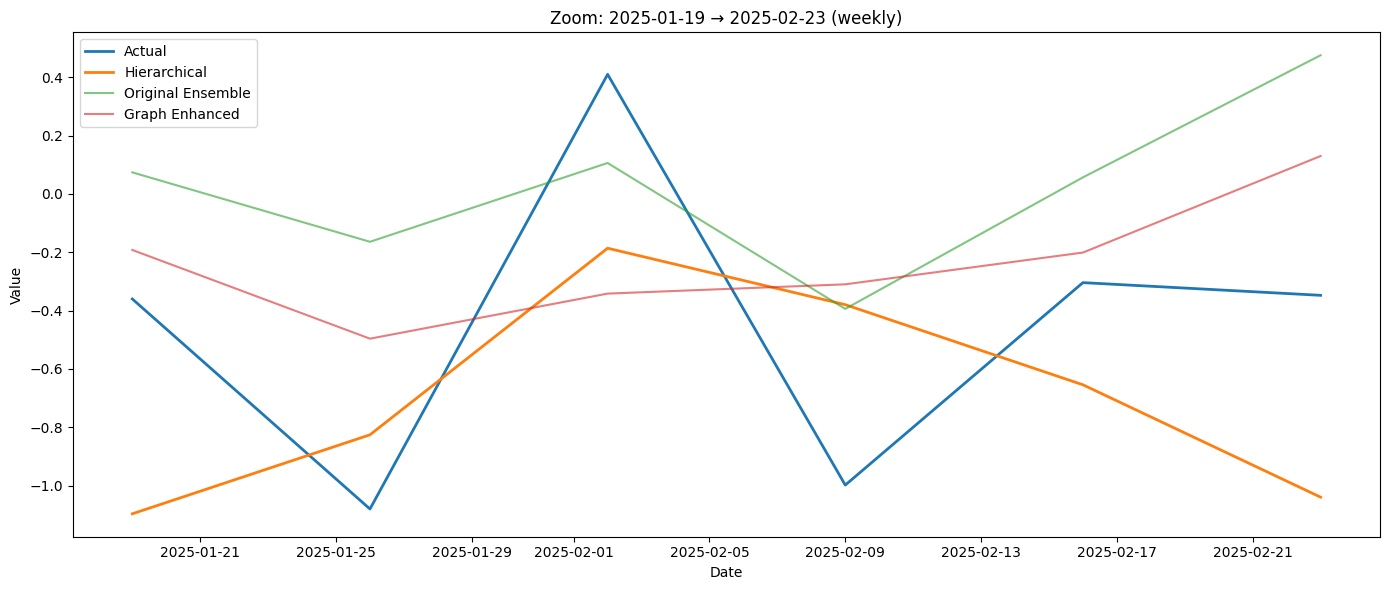

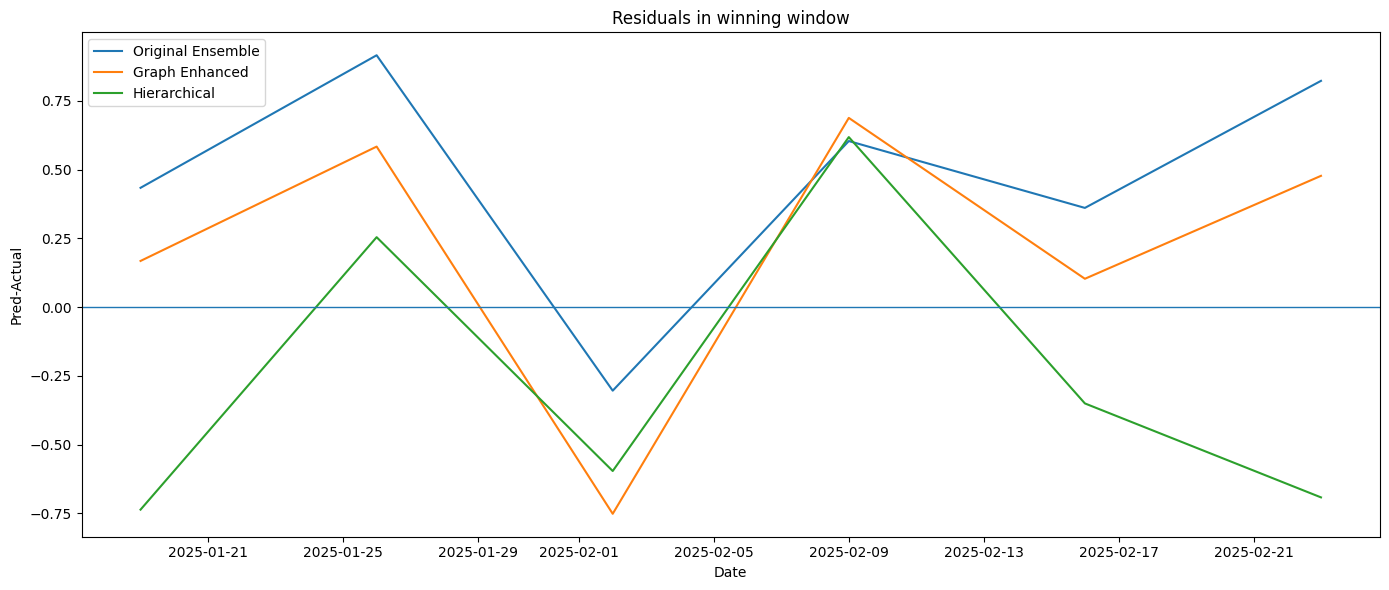

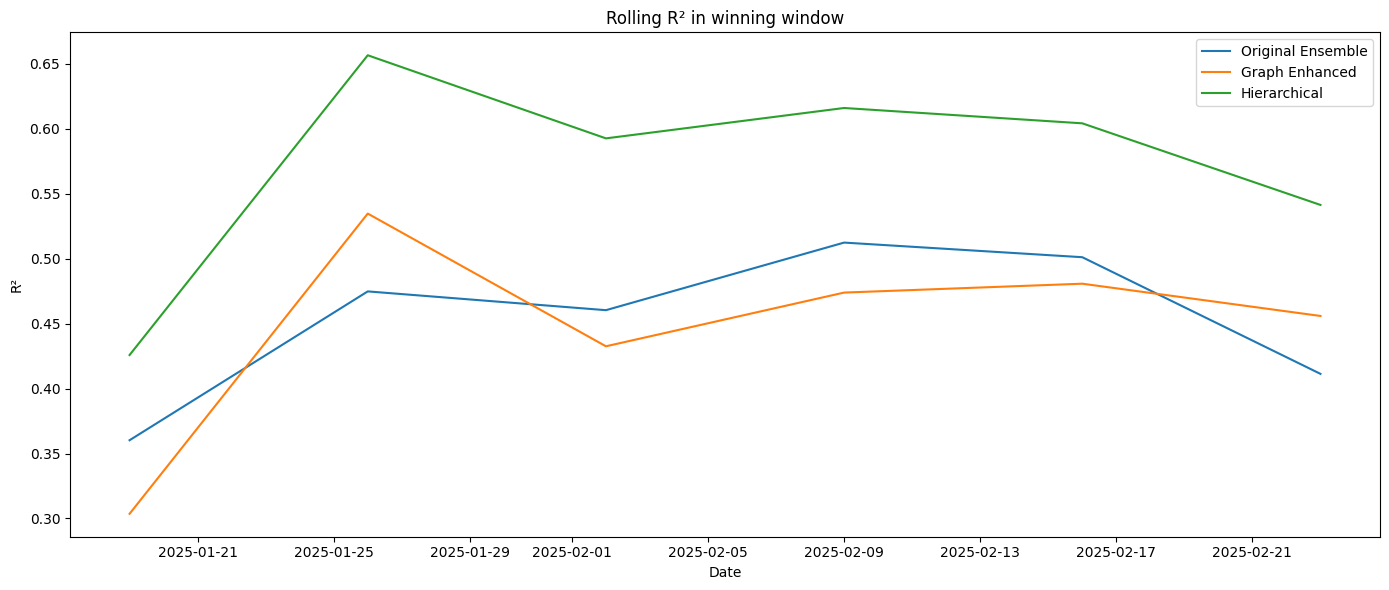

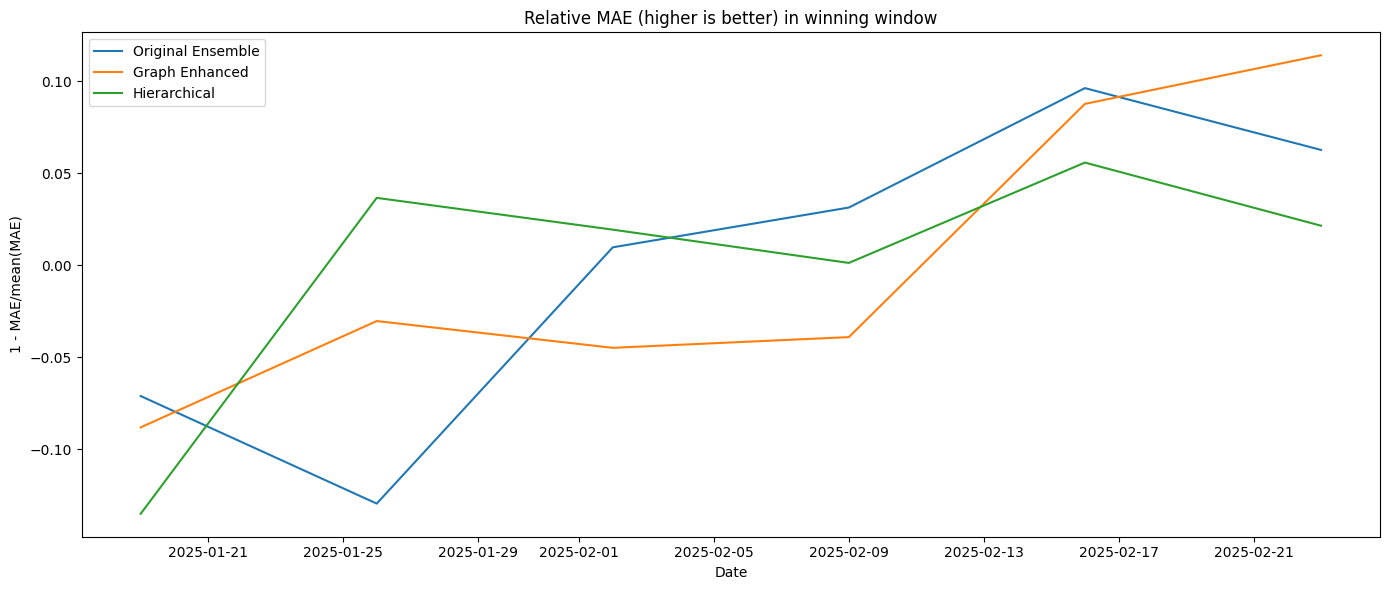

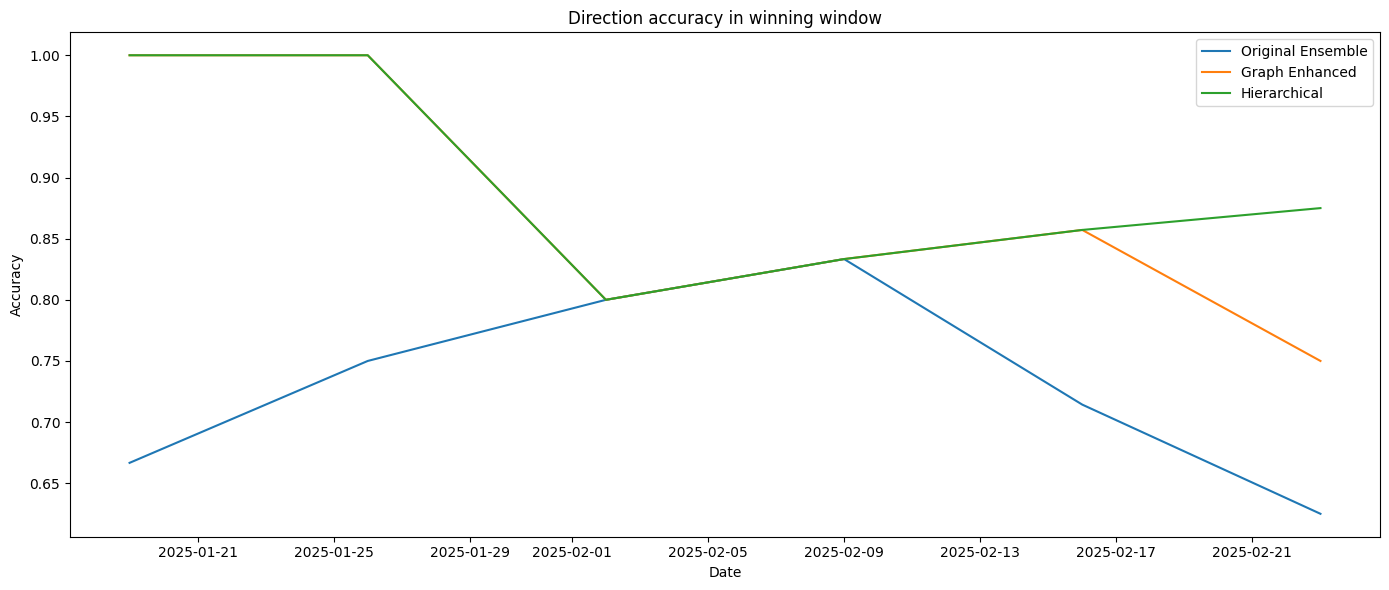

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def _align(y, x, dates):
    y = np.asarray(y, float).flatten()
    x = np.asarray(x, float).flatten()
    n = min(len(y), len(x), len(dates))
    d = pd.to_datetime(dates[:n])
    df = pd.DataFrame({"Actual": y[:n], "Pred": x[:n]}, index=d).sort_index()
    return df.loc[~df["Actual"].isna()]

dates = list(globals().get("test_predictions", {}).keys())
frames = {}
if "ensemble_pred" in globals(): frames["Original Ensemble"] = _align(y_test, ensemble_pred, dates)
if "enhanced_ensemble_pred" in globals(): frames["Graph Enhanced"] = _align(y_test, enhanced_ensemble_pred, dates)
if "hierarchical_predictions" in globals(): frames["Hierarchical"] = _align(y_test, hierarchical_predictions, dates)
if "Hierarchical" not in frames: raise ValueError("Hierarchical predictions missing")

def _weekly(df):
    return df.resample("W").mean()

W = {k: _weekly(v) for k,v in frames.items()}
idx = sorted(set().union(*[v.index for v in W.values()]))
W = {k: v.reindex(idx).interpolate() for k,v in W.items()}

win = 8
roll = {}
for k,df in W.items():
    y = df["Actual"]; x = df["Pred"]
    r2 = pd.Series(np.nan, index=df.index)
    mae = pd.Series(np.nan, index=df.index)
    acc = pd.Series(np.nan, index=df.index)
    for i in range(len(df)):
        j = max(0, i-win+1)
        yy = y.iloc[j:i+1].values
        xx = x.iloc[j:i+1].values
        if len(yy)>=3 and np.isfinite(yy).all() and np.isfinite(xx).all():
            r2.iloc[i] = r2_score(yy, xx)
            mae.iloc[i] = mean_absolute_error(yy, xx)
            acc.iloc[i] = np.mean(np.sign(yy)==np.sign(xx))
    roll[k] = pd.DataFrame({"R2": r2, "MAE": mae, "ACC": acc})

dfr = pd.concat({k:v for k,v in roll.items()}, axis=1)
best_r2 = dfr.xs("R2", axis=1, level=1).idxmax(1)
best_mae = dfr.xs("MAE", axis=1, level=1).idxmin(1)
best_acc = dfr.xs("ACC", axis=1, level=1).idxmax(1)
wins = (best_r2=="Hierarchical").astype(int) + (best_mae=="Hierarchical").astype(int) + (best_acc=="Hierarchical").astype(int)
mask = wins>=2

spans = []
on = False; start=None
for t, m in mask.items():
    if m and not on: on=True; start=t
    if (not m or t==mask.index[-1]) and on:
        end = t if m else prev
        spans.append((start, end, int((end-start).days)))
        on=False
    prev = t

spans = sorted(spans, key=lambda x: x[2], reverse=True)
if not spans: raise ValueError("No windows where Hierarchical wins ≥2/3 metrics")

top = spans[:3]
print("Top windows where Hierarchical wins ≥2/3 metrics:")
for s,e,_ in top:
    sub = dfr.loc[s:e]
    r2h = sub[("Hierarchical","R2")].mean()
    maeh = sub[("Hierarchical","MAE")].mean()
    acch = sub[("Hierarchical","ACC")].mean()
    lines = []
    for name in [k for k in frames if k!="Hierarchical"]:
        lines.append(f"{name}: R2={sub[(name,'R2')].mean():.3f} MAE={sub[(name,'MAE')].mean():.3f} ACC={sub[(name,'ACC')].mean():.3f}")
    print(f"{s.date()} → {e.date()} | Hierarchical R2={r2h:.3f} MAE={maeh:.3f} ACC={acch:.3f}")
    for L in lines: print("  "+L)

s,e,_ = top[0]
dh = W["Hierarchical"].loc[s:e]
plt.figure(figsize=(14,6))
plt.plot(dh.index, dh["Actual"], label="Actual", linewidth=2)
plt.plot(dh.index, dh["Pred"], label="Hierarchical", linewidth=2)
for name,df in W.items():
    if name=="Hierarchical": continue
    plt.plot(df.loc[s:e].index, df.loc[s:e]["Pred"], alpha=0.6, label=name)
plt.title(f"Zoom: {s.date()} → {e.date()} (weekly)")
plt.xlabel("Date"); plt.ylabel("Value"); plt.legend()
plt.tight_layout(); plt.show()

plt.figure(figsize=(14,6))
for name,df in W.items():
    r = (df["Pred"]-df["Actual"]).loc[s:e]
    plt.plot(r.index, r, label=name)
plt.axhline(0, linewidth=1)
plt.title("Residuals in winning window")
plt.xlabel("Date"); plt.ylabel("Pred-Actual"); plt.legend()
plt.tight_layout(); plt.show()

plt.figure(figsize=(14,6))
for name in frames:
    rr = roll[name].loc[s:e]
    plt.plot(rr.index, rr["R2"], label=name)
plt.title("Rolling R² in winning window")
plt.xlabel("Date"); plt.ylabel("R²"); plt.legend()
plt.tight_layout(); plt.show()

plt.figure(figsize=(14,6))
for name in frames:
    rr = roll[name].loc[s:e]
    plt.plot(rr.index, 1.0-rr["MAE"]/rr["MAE"].mean(), label=name)
plt.title("Relative MAE (higher is better) in winning window")
plt.xlabel("Date"); plt.ylabel("1 - MAE/mean(MAE)"); plt.legend()
plt.tight_layout(); plt.show()

plt.figure(figsize=(14,6))
for name in frames:
    rr = roll[name].loc[s:e]
    plt.plot(rr.index, rr["ACC"], label=name)
plt.title("Direction accuracy in winning window")
plt.xlabel("Date"); plt.ylabel("Accuracy"); plt.legend()
plt.tight_layout(); plt.show()


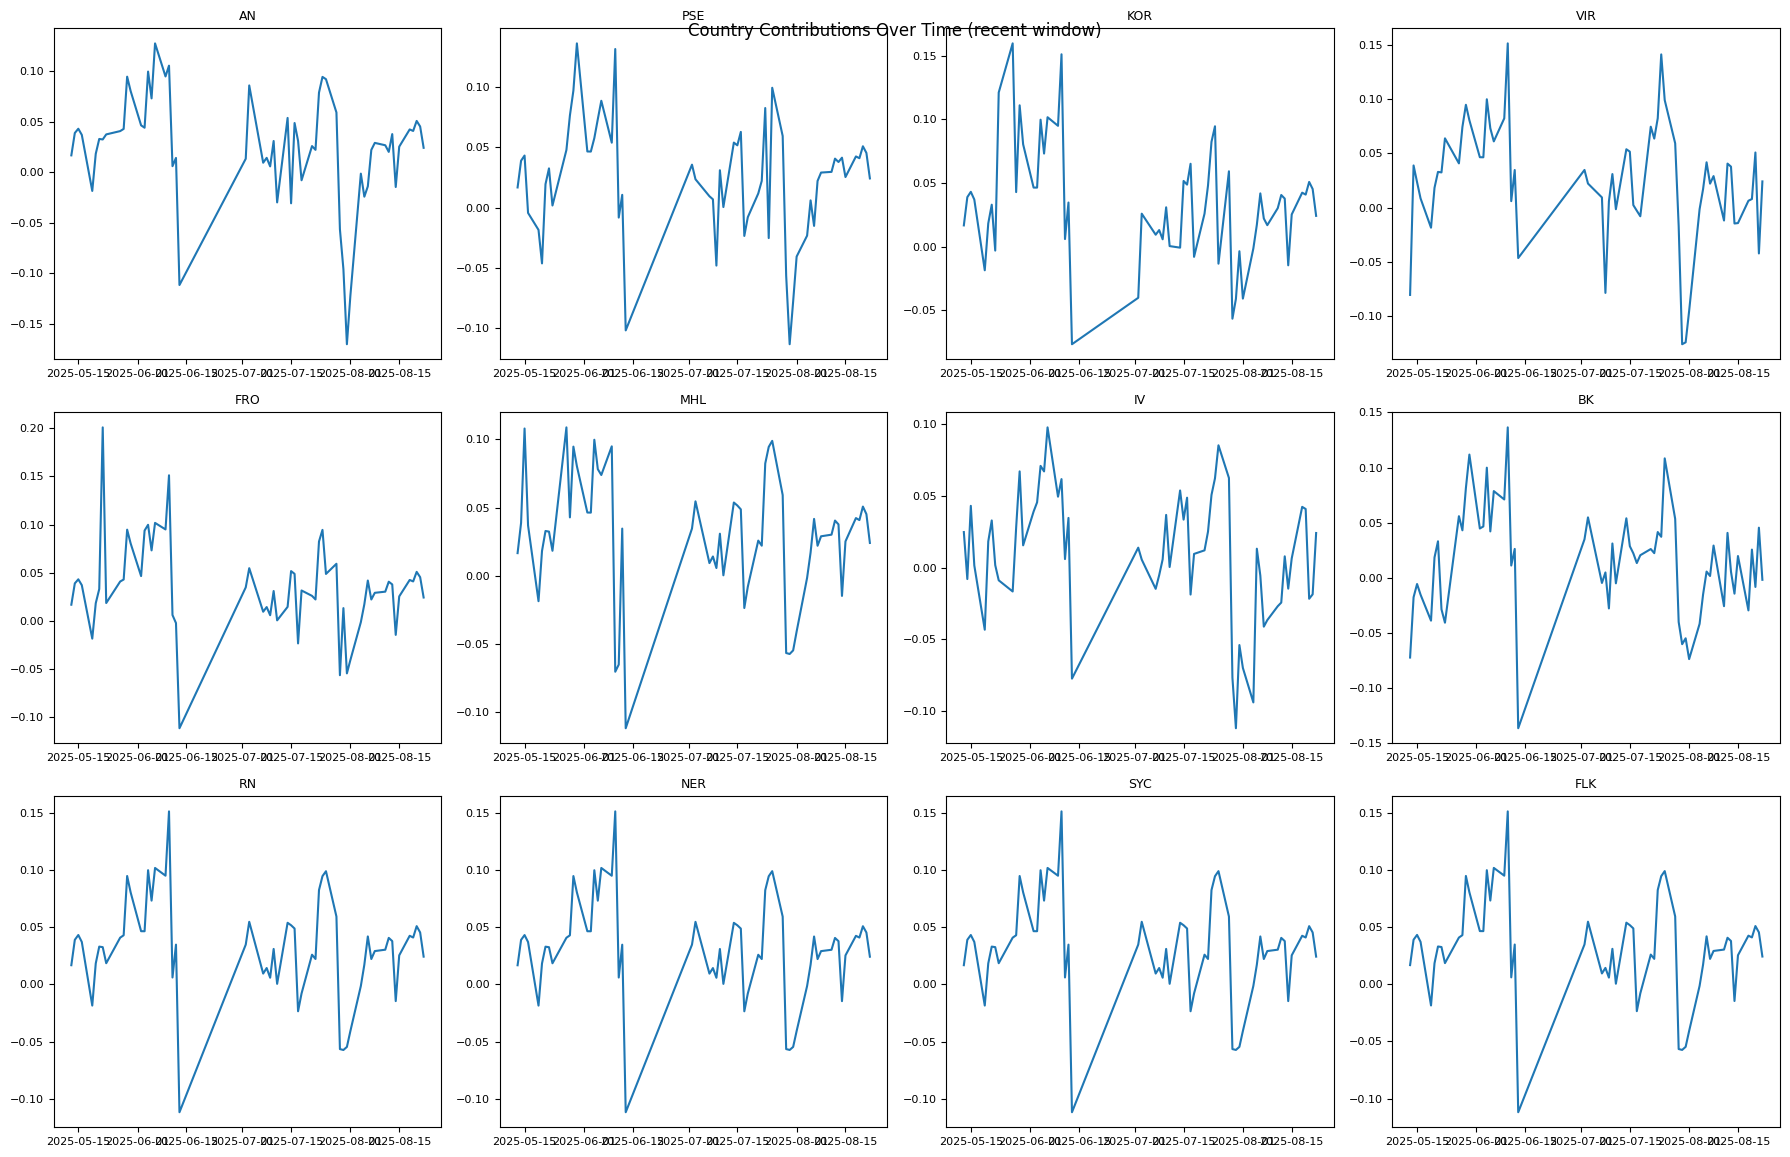

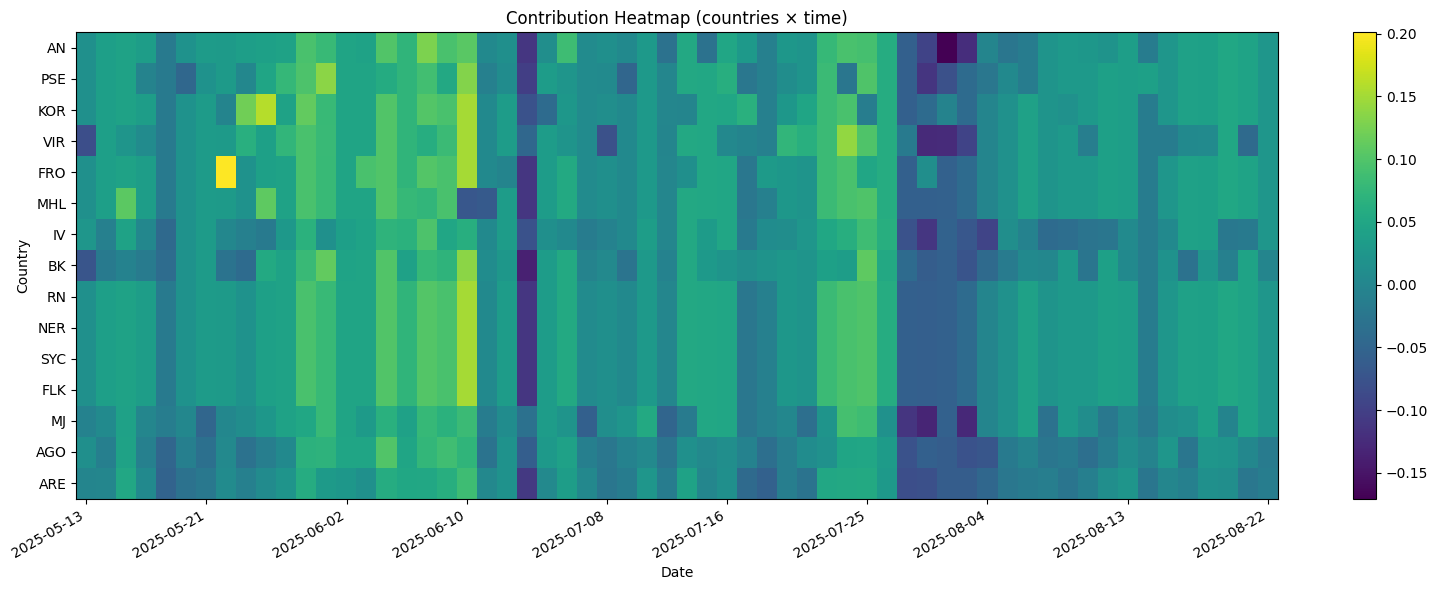

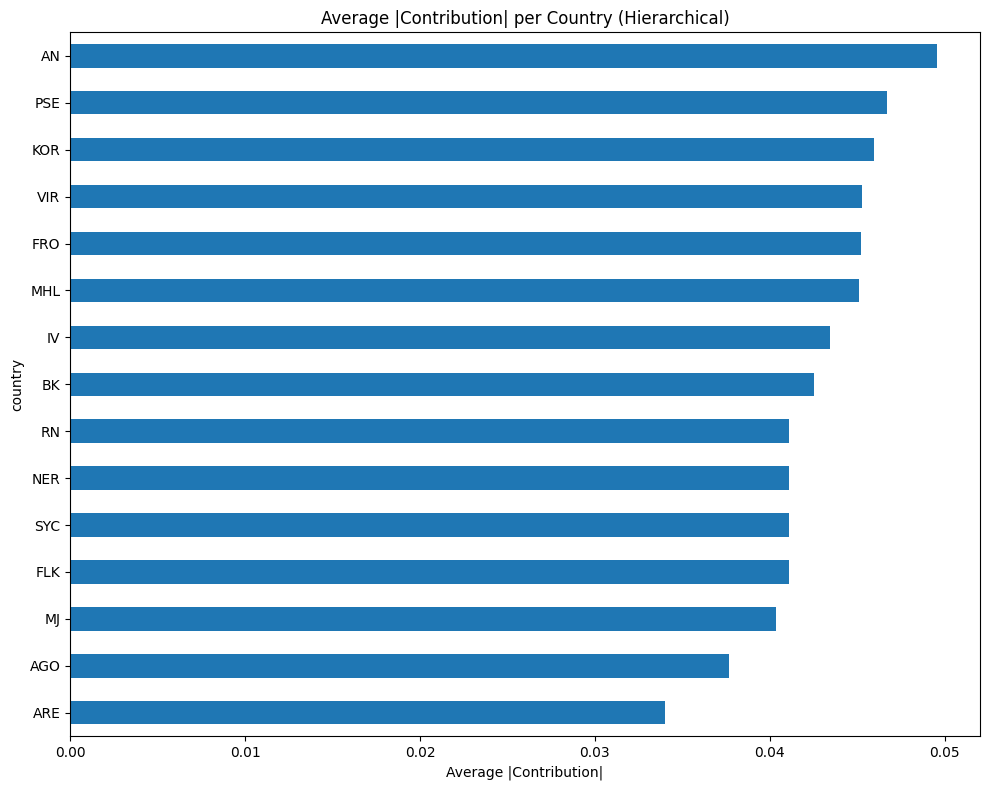

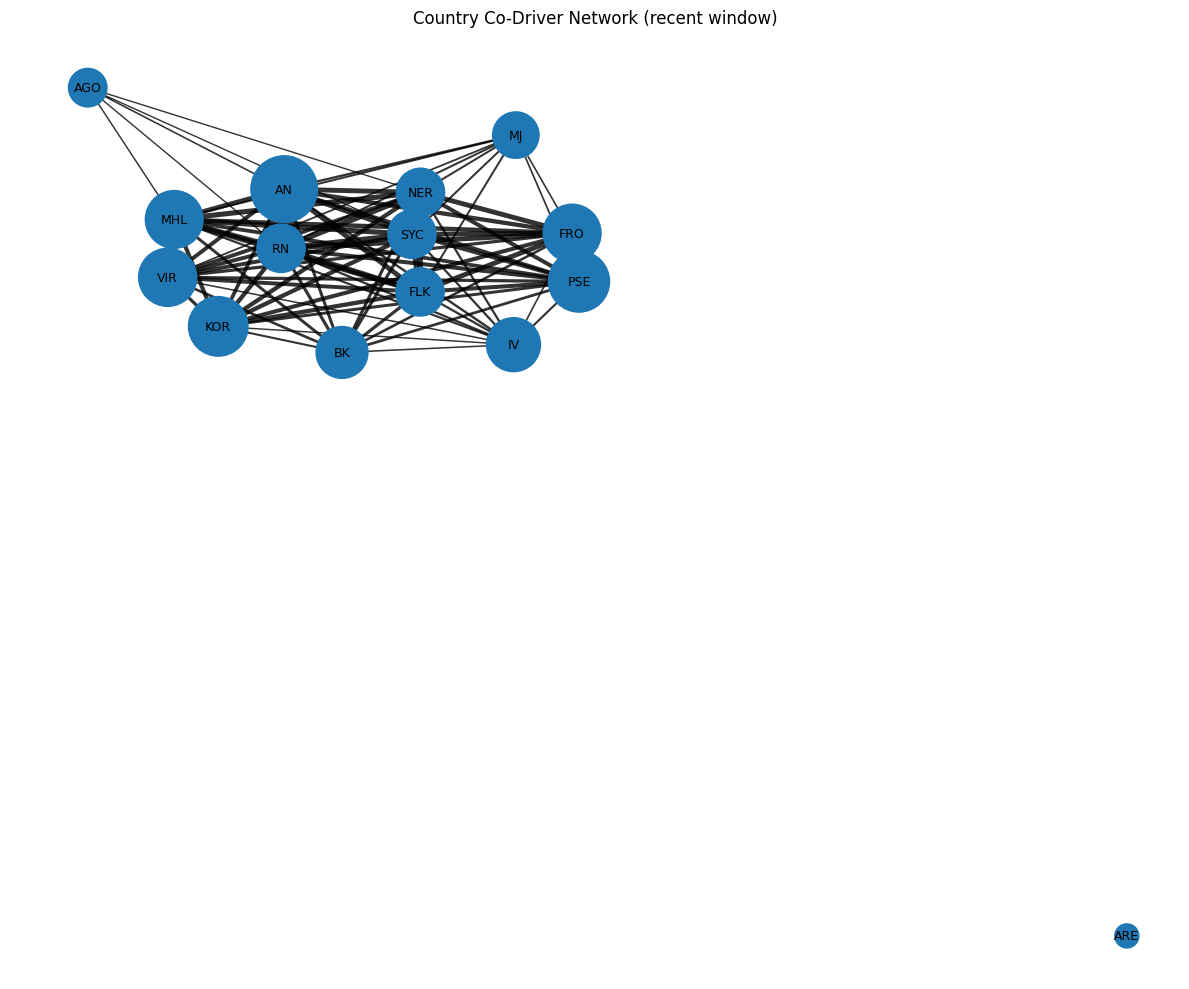

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

try:
    import networkx as nx
except Exception:
    nx = None

hist = globals().get("attention_history", [])
if not hist:
    raise ValueError("attention_history is empty")

rows = []
for r in hist:
    d = pd.to_datetime(r["date"])
    for c, v in r.get("country_contributions", {}).items():
        rows.append({"date": d, "country": c, "contribution": float(v), "abs_contribution": abs(float(v))})
contrib_df = pd.DataFrame(rows)
if contrib_df.empty:
    raise ValueError("no contributions found")

avg_abs = contrib_df.groupby("country")["abs_contribution"].mean().sort_values(ascending=False)
top_k = min(15, len(avg_abs))
top_countries = avg_abs.index[:top_k].tolist()

last_k = 60
last_dates = sorted(contrib_df["date"].unique())[-last_k:]
sub = contrib_df[contrib_df["date"].isin(last_dates) & contrib_df["country"].isin(top_countries)]
pivot = sub.pivot_table(index="date", columns="country", values="contribution", aggfunc="sum").fillna(0.0).reindex(columns=top_countries)

plt.figure(figsize=(18, 12))
m = min(12, len(top_countries))
cols = 4
rows_grid = int(np.ceil(m / cols))
for i, c in enumerate(top_countries[:m], 1):
    ax = plt.subplot(rows_grid, cols, i)
    ax.plot(pivot.index, pivot[c])
    ax.set_title(c, fontsize=9)
    ax.tick_params(labelsize=8)
    if i % cols != 1:
        ax.set_ylabel("")
    if i <= (rows_grid - 1) * cols:
        ax.set_xlabel("")
plt.suptitle("Country Contributions Over Time (recent window)", y=0.95)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 6))
plt.imshow(pivot.values.T, aspect="auto", interpolation="nearest")
plt.yticks(ticks=np.arange(len(top_countries)), labels=top_countries)
plt.xticks(ticks=np.linspace(0, len(pivot.index)-1, min(10, len(pivot.index))).astype(int),
           labels=[pd.to_datetime(pivot.index[i]).strftime("%Y-%m-%d") for i in np.linspace(0, len(pivot.index)-1, min(10, len(pivot.index))).astype(int)], rotation=30, ha="right")
plt.title("Contribution Heatmap (countries × time)")
plt.xlabel("Date")
plt.ylabel("Country")
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
avg_abs.head(top_k).iloc[::-1].plot(kind="barh")
plt.title("Average |Contribution| per Country (Hierarchical)")
plt.xlabel("Average |Contribution|")
plt.tight_layout()
plt.show()

co = {}
for d, g in sub.groupby("date"):
    s = g.set_index("country")["abs_contribution"].sort_values(ascending=False)
    names = s.index.tolist()
    for i in range(len(names)):
        for j in range(i+1, len(names)):
            a, b = names[i], names[j]
            w = min(s.iloc[i], s.iloc[j])
            key = tuple(sorted((a, b)))
            co[key] = co.get(key, 0.0) + float(w)
edges = sorted([(a, b, w) for (a, b), w in co.items()], key=lambda x: x[2], reverse=True)[:80]

if nx is not None and len(edges) > 0:
    G = nx.Graph()
    for c in top_countries:
        G.add_node(c, weight=float(avg_abs.get(c, 0.0)))
    for a, b, w in edges:
        if a in G and b in G:
            G.add_edge(a, b, weight=float(w))
    sizes = np.array([G.nodes[n]["weight"] for n in G.nodes()])
    if sizes.size == 0:
        sizes = np.array([1.0])
    denom = np.ptp(sizes) if np.ptp(sizes) != 0 else 1.0
    sizes = 300 + 2000 * (sizes - sizes.min()) / denom
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, seed=42, k=0.6)
    nx.draw_networkx_nodes(G, pos, node_size=sizes)
    if G.number_of_edges() > 0:
        eweights = np.array([G[u][v]["weight"] for u, v in G.edges()])
        eweights = 1.0 + 3.0 * (eweights - eweights.min()) / (np.ptp(eweights) if np.ptp(eweights) != 0 else 1.0)
        nx.draw_networkx_edges(G, pos, width=eweights.tolist(), alpha=0.8)
    nx.draw_networkx_labels(G, pos, font_size=9)
    plt.title("Country Co-Driver Network (recent window)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    mat = np.zeros((len(top_countries), len(top_countries)))
    idx = {c:i for i,c in enumerate(top_countries)}
    for a,b,w in edges:
        if a in idx and b in idx:
            ia, ib = idx[a], idx[b]
            mat[ia, ib] = mat[ib, ia] = w
    plt.figure(figsize=(8, 7))
    plt.imshow(mat, interpolation="nearest")
    plt.xticks(ticks=np.arange(len(top_countries)), labels=top_countries, rotation=90)
    plt.yticks(ticks=np.arange(len(top_countries)), labels=top_countries)
    plt.title("Country Co-Driver Matrix (fallback)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()
